In [1]:
import torch
model, alphabet = torch.hub.load("facebookresearch/esm:main", "esm1v_t33_650M_UR90S_1")

Using cache found in /home/hengshi/.cache/torch/hub/facebookresearch_esm_main
/home/hengshi/.cache/torch/hub/facebookresearch_esm_main/esm/pretrained.py:148: UserWarning: Regression weights not found, predicting contacts will not produce correct results.
  warnings.warn(


In [2]:
import torch
import esm

# Load ESM-1b model
model, alphabet = esm.pretrained.esm1v_t33_650M_UR90S_1()
batch_converter = alphabet.get_batch_converter()

In [3]:
data = [
    ("protein1", "MKTVRQERLKSIVRILERSKEPVSGAQLAEELSVSRQVIVQDIAYLRSLGYNIVATPRGYVLAGG"),
    ("protein2", "KALTARQQEVFDLIRDHISQTGMPPTRAEIAQRLGFRSPNAAEEHLKALARKGVIEIVSGASRGIRLLQEE"),
    ("protein2 with mask","KALTARQQEVFDLIRD<mask>ISQTGMPPTRAEIAQRLGFRSPNAAEEHLKALARKGVIEIVSGASRGIRLLQEE"),
    ("protein3",  "K A <mask> I S Q"),
]
batch_labels, batch_strs, batch_tokens = batch_converter(data)

# Extract per-residue representations (on CPU)
with torch.no_grad():
    results = model(batch_tokens, repr_layers=[33], return_contacts=True)
token_representations = results["representations"][33]


In [4]:
token_representations.shape

torch.Size([4, 73, 1280])

In [5]:
# Generate per-sequence representations via averaging
# NOTE: token 0 is always a beginning-of-sequence token, so the first residue is token 1.
sequence_representations = []
for i, (_, seq) in enumerate(data):
    sequence_representations.append(token_representations[i, 1 : len(seq) + 1].mean(0))

In [6]:
sequence_representations

[tensor([-0.0507,  0.0070,  0.0155,  ...,  0.0303,  0.0514,  0.0756]),
 tensor([-0.0845, -0.0069,  0.0529,  ..., -0.0397, -0.0275,  0.0623]),
 tensor([-0.0620, -0.0037,  0.0547,  ..., -0.0345, -0.0419,  0.0495]),
 tensor([-0.0939,  0.0107, -0.0848,  ..., -0.3075,  0.1008, -0.0047])]

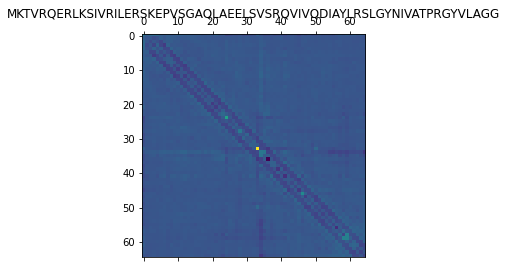

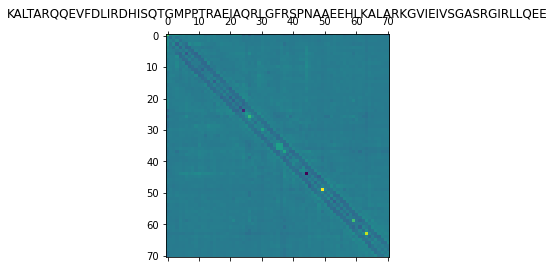

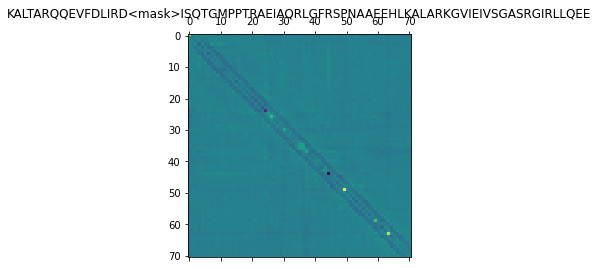

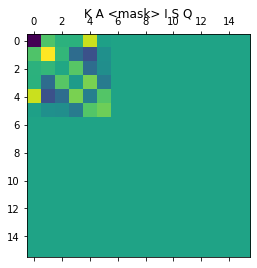

In [7]:
# Look at the unsupervised self-attention map contact predictions
import matplotlib.pyplot as plt
for (_, seq), attention_contacts in zip(data, results["contacts"]):
    plt.matshow(attention_contacts[: len(seq), : len(seq)])
    plt.title(seq)
    plt.show()

In [8]:
token_representations[i, 1 : len(seq) + 1].shape

torch.Size([16, 1280])

In [9]:
token_representations.shape

torch.Size([4, 73, 1280])

# Preprocess data with variant perturbations

In [1]:
import pandas as pd

In [112]:
exdata = pd.read_csv('GSE161824_A549_KRAS_processed.expr.csv.gz', compression = 'gzip')

In [113]:
exdata.head()

,Unnamed: 0,SAMD11,HES4,ISG15,ERRFI1,ENO1,EFHD2,EPHA2,UBR4,CAMK2N1,...,GTSE1,CTA-29F11.1,CCT8,EVA1C,CBR3,TFF1,PDXK,MT-ND1,MT-ATP6,MT-ND6
0,AGAATAGCAAAGGTGCch1,-0.475639,-0.603496,-0.326901,0.082439,-1.849039,0.820450,-0.527545,0.685223,1.212849,...,-0.966461,0.572137,-0.606646,-0.596926,-0.537216,4.060974,-1.745349,-2.605345,0.718420,-0.314252
1,AGGGTGAAGCTCTCGGch1,-0.464881,0.270650,-0.362514,0.129428,-0.327838,-0.649362,-0.692366,0.577036,-0.864933,...,0.880348,-0.395378,0.213405,1.830761,-0.508915,-0.274453,-0.667094,0.063176,-0.050541,0.365292
2,CAAGAAAAGACAAGCCch1,-0.466140,0.672429,-0.309800,0.354398,0.063893,-0.346248,-0.472002,-0.520825,-0.785602,...,-0.769988,-0.604668,-1.349746,-0.598015,-0.487766,-0.257752,-1.671023,-0.418839,-0.545874,0.044365
3,CTACGTCAGTGGAGAAch1,-0.451495,-0.654517,-0.336792,-0.738492,-0.947742,-1.294227,1.326682,1.389035,2.030581,...,-0.681636,-0.750243,0.369838,1.632521,-0.452601,-0.268676,0.043232,-0.216571,0.755075,-0.264658
4,CTGAAGTGTAAAGGAGch1,-0.450684,-0.622883,2.262108,-0.775162,-1.297039,-0.276864,-0.612407,-0.598665,-0.878863,...,-0.693941,-0.669953,0.818721,0.473520,-0.436037,-0.272547,1.035861,0.063702,0.859067,0.828217


In [114]:
exdata.shape

(90262, 1146)

In [115]:
exdata_values = exdata.iloc[:, 1:].values
exdata_values.min(), exdata_values.max()

(-15.205632000000001, 10.0)

In [2]:
variant = pd.read_csv('GSE161824_A549_KRAS_variant2cell.csv.gz', compression = 'gzip', sep = '\t')
variant.head()

,G60S,G60D,G13C,P34R,G13E,N26Y,Q61P,K147T,AG11TD,A146T,...,T158A,T20M,G77A,Q61K,S136N,V14L,R149K,Y166H,cell,batch
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,GCAATCAGTCAGAAGCch32,32
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,AAGTCTGAGACCCACCch27,27
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,GTTCATTGTCCTCGTCch20,20
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,TTGCCGTGTGGTGTAGch32,32
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CCACCTAAGAAGGACAch23,23


In [3]:
variant.shape

(153365, 100)

In [7]:
variant.head()

,G60S,G60D,G13C,P34R,G13E,N26Y,Q61P,K147T,AG11TD,A146T,...,T158A,T20M,G77A,Q61K,S136N,V14L,R149K,Y166H,cell,batch
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,GCAATCAGTCAGAAGCch32,32
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,AAGTCTGAGACCCACCch27,27
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,GTTCATTGTCCTCGTCch20,20
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,TTGCCGTGTGGTGTAGch32,32
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CCACCTAAGAAGGACAch23,23


In [5]:
variant_new = pd.read_csv('./raw_data/GSE161824_A549_KRAS.variants2cell.csv.gz', compression = 'gzip', sep = '\t')
variant_new.shape

(150044, 103)

In [6]:
variant_new.head()

,batch,n_counts,T20R,T158T,M111L,V112I,T50I,G13C,Q22H,L159S,...,S136N,E63K,I36M,A59T,A155G,A66A,T144T,variant,variant.detailed_multi,cell
0,0,25694.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,unassigned,unassigned,AAACCTGCAACGCACC-1-0
1,0,34868.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,T50T,T50T,AAACCTGCAATGGTCT-1-0
2,0,25170.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,unassigned,unassigned,AAACCTGCAGGACGTA-1-0
3,0,31500.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,unassigned,unassigned,AAACCTGCAGTAAGAT-1-0
4,0,22654.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,T127T,T127T,AAACGGGAGACAGAGA-1-0


In [9]:
len(set(variant.columns[:-2]) & set(variant_new.columns[2:-3]))

98

In [11]:
len(variant.columns[:-2]), len(variant_new.columns[2:-3])

(98, 98)

In [1]:
from esm import FastaBatchedDataset

data_all = FastaBatchedDataset.from_file('KRAS.fasta')
batches = data_all.get_batch_indices(4096, extra_toks_per_seq = 1)
data_loader = torch.utils.data.DataLoader(
    data_all, collate_fn=alphabet.get_batch_converter(), batch_sampler=batches
    )
for i, data in enumerate(data_loader):
    print(i)

NameError: name 'torch' is not defined

In [118]:
data

(['sp|P01116|RASK_HUMAN GTPase KRas OS=Homo sapiens OX=9606 GN=KRAS PE=1 SV=1'],
 ['MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVIDGETCLLDILDTAGQEEYSAMRDQYMRTGEGFLCVFAINNTKSFEDIHHYREQIKRVKDSEDVPMVLVGNKCDLPSRTVDTKQAQDLARSYGIPFIETSAKTRQRVEDAFYTLVREIRQYRLKKISKEEKTPGCVKIKKCIIM'],
 tensor([[ 0, 20, 11,  9, 19, 15,  4,  7,  7,  7,  6,  5,  6,  6,  7,  6, 15,  8,
           5,  4, 11, 12, 16,  4, 12, 16, 17, 21, 18,  7, 13,  9, 19, 13, 14, 11,
          12,  9, 13,  8, 19, 10, 15, 16,  7,  7, 12, 13,  6,  9, 11, 23,  4,  4,
          13, 12,  4, 13, 11,  5,  6, 16,  9,  9, 19,  8,  5, 20, 10, 13, 16, 19,
          20, 10, 11,  6,  9,  6, 18,  4, 23,  7, 18,  5, 12, 17, 17, 11, 15,  8,
          18,  9, 13, 12, 21, 21, 19, 10,  9, 16, 12, 15, 10,  7, 15, 13,  8,  9,
          13,  7, 14, 20,  7,  4,  7,  6, 17, 15, 23, 13,  4, 14,  8, 10, 11,  7,
          13, 11, 15, 16,  5, 16, 13,  4,  5, 10,  8, 19,  6, 12, 14, 18, 12,  9,
          11,  8,  5, 15, 11, 10, 16, 10,  7,  9, 13,  5, 18, 19, 1

In [119]:
len(data[1][0])

189

In [120]:
base_protein = data[1][0]

In [121]:
base_protein

'MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVIDGETCLLDILDTAGQEEYSAMRDQYMRTGEGFLCVFAINNTKSFEDIHHYREQIKRVKDSEDVPMVLVGNKCDLPSRTVDTKQAQDLARSYGIPFIETSAKTRQRVEDAFYTLVREIRQYRLKKISKEEKTPGCVKIKKCIIM'

In [122]:
changes = variant.columns
changes = list(changes)
changes

['G60S',
 'G60D',
 'G13C',
 'P34R',
 'G13E',
 'N26Y',
 'Q61P',
 'K147T',
 'AG11TD',
 'A146T',
 'S17S',
 'L159S',
 'G13R',
 'V14I',
 'T50P',
 'K5E',
 'F141L',
 'K179R',
 'I36M',
 'R164Q',
 'T20T',
 'T74A',
 'T144T',
 'V8V',
 'Q61R',
 'A59T',
 'M170L',
 'Q61A',
 'A146V',
 'T144P',
 'A59E',
 'A66A',
 'Q99E',
 'G12S',
 'G12I',
 'T74T',
 'K147N',
 'K117N',
 'G12V',
 'I163S',
 'A59G',
 'G60V',
 'T50T',
 'Q22K',
 'K178K',
 'K169K',
 'G12Y',
 'G75A',
 'A130V',
 'G12A',
 'R41K',
 'K117R',
 'G12C',
 'K88K',
 'G13V',
 'Q61L',
 'Q25H',
 'L52F',
 'E31K',
 'C185Y',
 'AG59GV',
 'L79I',
 'D119G',
 'A155G',
 'T58I',
 'Q22H',
 'Q61H',
 'V112I',
 'M111L',
 'D57N',
 'G12F',
 'T127T',
 'D33E',
 'T20R',
 'WT',
 'P34L',
 'P110S',
 'D173D',
 'L19F',
 'R135T',
 'D30D',
 'C118S',
 'A146P',
 'K176Q',
 'G12R',
 'E63K',
 'T158T',
 'T50I',
 'R68S',
 'G12D',
 'T158A',
 'T20M',
 'G77A',
 'Q61K',
 'S136N',
 'V14L',
 'R149K',
 'Y166H',
 'cell',
 'batch']

In [123]:
changes = changes[:-2]
changes

['G60S',
 'G60D',
 'G13C',
 'P34R',
 'G13E',
 'N26Y',
 'Q61P',
 'K147T',
 'AG11TD',
 'A146T',
 'S17S',
 'L159S',
 'G13R',
 'V14I',
 'T50P',
 'K5E',
 'F141L',
 'K179R',
 'I36M',
 'R164Q',
 'T20T',
 'T74A',
 'T144T',
 'V8V',
 'Q61R',
 'A59T',
 'M170L',
 'Q61A',
 'A146V',
 'T144P',
 'A59E',
 'A66A',
 'Q99E',
 'G12S',
 'G12I',
 'T74T',
 'K147N',
 'K117N',
 'G12V',
 'I163S',
 'A59G',
 'G60V',
 'T50T',
 'Q22K',
 'K178K',
 'K169K',
 'G12Y',
 'G75A',
 'A130V',
 'G12A',
 'R41K',
 'K117R',
 'G12C',
 'K88K',
 'G13V',
 'Q61L',
 'Q25H',
 'L52F',
 'E31K',
 'C185Y',
 'AG59GV',
 'L79I',
 'D119G',
 'A155G',
 'T58I',
 'Q22H',
 'Q61H',
 'V112I',
 'M111L',
 'D57N',
 'G12F',
 'T127T',
 'D33E',
 'T20R',
 'WT',
 'P34L',
 'P110S',
 'D173D',
 'L19F',
 'R135T',
 'D30D',
 'C118S',
 'A146P',
 'K176Q',
 'G12R',
 'E63K',
 'T158T',
 'T50I',
 'R68S',
 'G12D',
 'T158A',
 'T20M',
 'G77A',
 'Q61K',
 'S136N',
 'V14L',
 'R149K',
 'Y166H']

In [124]:
start_char, char_place, end_char = [], [], []

In [125]:
for i in range(len(changes)):
    change = changes[i]
    if change == 'WT':
        loc_wt = i
        start_char.append('*')
        end_char.append('*')
        char_place.append(-1)
        continue
    j = 0
    if change[1].isnumeric() is False:
        start_char.append(change[0:2])
        loc_start = 2
    else:
        start_char.append(change[0])
        loc_start = 1
        
    j = len(change) - 1
    if change[j - 1].isnumeric() is False:
        end_char.append(change[(j - 1):])
        place = int(change[loc_start:(j-1)])
    else:
        end_char.append(change[j])
        place = int(change[loc_start:j])
    
    
    char_place.append(int(place))

In [126]:
changes_copy = changes.copy()
#changes_copy.remove('WT')

In [127]:
# check if starting is actually starting 
for i in range(len(start_char)):
    start = start_char[i]
    place = char_place[i]
    
    if start == '*':
        continue
        
    if i == 17 or i == 26 or i == 44 or i == 59 or i == 77:
        continue
        
    if len(start) == 1:
        if base_protein[place - 1] != start:
             break
    else:
        if base_protein[(place - 1): (place + 1)] != start:
            break
    

In [128]:
import numpy as np

In [129]:
loc_wt

74

In [130]:
len(start_char), len(changes)

(98, 98)

In [131]:
np.array(start_char)[[17, 26, 44, 59, 77, 76, 78]]

array(['K', 'M', 'K', 'C', 'D', 'P', 'L'], dtype='<U2')

In [132]:
for i in [17, 26, 44, 59, 77, 76, 78]:
    place = char_place[i]
    print(base_protein[place - 1])

G
K
P
K
K
P
L


In [133]:
gene_data = pd.read_csv('GSE161824_A549_KRAS_processed.genes.csv.gz', compression = 'gzip')
obs_data = pd.read_csv('GSE161824_A549_KRAS_processed.obs.csv.gz', compression = 'gzip')

In [134]:
gene_data.shape, obs_data.shape

((1145, 57), (90262, 82))

In [107]:
gene_data1 = pd.read_csv('GSE161824_A549_KRAS_processed.genes.csv.gz', compression = 'gzip')
gene_data2 = pd.read_csv('GSE161824_A549_TP53_processed.genes.csv.gz', compression = 'gzip')

In [108]:
gene_data2.head()

,Unnamed: 0,n_cells,highly_variable,means,dispersions,dispersions_norm,gene_program,PC0,PC1,PC2,...,PC40,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49
0,SAMD11,64435,True,0.276301,-0.185905,2.105339,5,-0.000526,-0.014463,0.012673,...,-0.033623,0.016420,0.099363,0.054405,0.030745,0.044842,0.042418,0.013417,-0.009664,0.042895
1,HES4,91456,True,0.429525,-0.005555,2.221569,6,-0.004204,-0.015121,0.001120,...,0.030669,0.068654,-0.034900,-0.045724,-0.031970,-0.038714,-0.100034,-0.014832,0.031307,-0.004463
2,ISG15,23020,True,0.080177,0.060937,3.552859,2,0.004311,0.028451,0.009427,...,0.029864,0.050663,0.074177,-0.002959,0.032204,0.043858,-0.033987,0.081855,-0.011679,0.026415
3,TMEM52,4224,True,0.013766,-0.237663,1.801821,5,-0.003038,0.002034,-0.003348,...,0.019457,0.042758,-0.017934,0.011150,0.026850,0.019509,0.013827,0.048788,0.035998,0.003150
4,ERRFI1,80708,True,0.321463,-0.393491,0.888023,6,0.006198,-0.028958,-0.001442,...,0.049075,0.009082,-0.028299,0.005919,-0.060137,-0.057532,-0.042695,0.014487,-0.047195,-0.045891


In [111]:
len(list(set(list(gene_data1['Unnamed: 0'])) & set(list(gene_data2['Unnamed: 0'])))), gene_data1.shape, gene_data2.shape

(939, (1145, 57), (1224, 57))

In [135]:
variant.iloc[:, :-2].isna().sum().sum()

0

In [136]:
variant.iloc[:, :-2].sum(1).min()

0.0

In [137]:
variant_meta = exdata.loc[:, ['Unnamed: 0']].merge(variant, left_on = 'Unnamed: 0', right_on = 'cell', how = 'inner')

In [138]:
variant_meta.shape

(89271, 101)

In [139]:
loc_wt

74

In [140]:
value_variant = variant_meta.iloc[:, 1:-2].values

In [141]:
value_variant[:, [17, 26, 44, 59, 77, loc_wt]].sum(0)

array([2872., 3593., 4084., 2864., 3163., 1916.])

In [142]:
np.unique(value_variant[:, [17, 26, 44, 59, 77, loc_wt]])

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 23., 27., 40.])

In [143]:
value_variant.sum(1).min()

0.0

In [144]:
idx_no_define = np.where(value_variant[:, [17, 26, 44, 59, 77, loc_wt]].sum(1) > 0)[0]
idx_yes_define = np.setdiff1d(np.array(list(range(value_variant.shape[0]))), idx_no_define)
value_variant.shape, len(idx_no_define), len(idx_yes_define)

((89271, 98), 5783, 83488)

In [145]:
variant_meta_define = variant_meta.iloc[idx_yes_define, :]
variant_meta_define.head()

,Unnamed: 0,G60S,G60D,G13C,P34R,G13E,N26Y,Q61P,K147T,AG11TD,...,T158A,T20M,G77A,Q61K,S136N,V14L,R149K,Y166H,cell,batch
0,AGAATAGCAAAGGTGCch1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,AGAATAGCAAAGGTGCch1,1
1,AGGGTGAAGCTCTCGGch1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,AGGGTGAAGCTCTCGGch1,1
2,CAAGAAAAGACAAGCCch1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CAAGAAAAGACAAGCCch1,1
3,CTACGTCAGTGGAGAAch1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CTACGTCAGTGGAGAAch1,1
4,CTGAAGTGTAAAGGAGch1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CTGAAGTGTAAAGGAGch1,1


In [146]:
idx_removed_variants = np.array( [17, 26, 44, 59, 77, loc_wt])
idx_kept_variants = np.setdiff1d(np.array(list(range(98))), idx_removed_variants)

In [147]:
len(idx_kept_variants)

92

In [148]:
#idx_with_variant = np.where(variant_meta_define.iloc[:, 1:-2].values[:, idx_kept_variants].sum(1) > 0)[0]

In [149]:
row, col = np.where(variant_meta_define.iloc[:, 1:-2].values[:, idx_kept_variants] > 0)

In [130]:
variant_meta_define.iloc[:, 1:-2].values[:, idx_kept_variants][:10, 62]

NameError: name 'variant_meta_define' is not defined

In [151]:
variant_meta_define.iloc[:, 1:-2].values[:, idx_kept_variants].shape

(83488, 92)

In [152]:
variant_meta_define.iloc[:, 1:-2].values[:, idx_kept_variants].sum(1).min()

0.0

In [153]:
row.shape, np.unique(row).shape, col.shape, np.unique(col).shape

((84443,), (83479,), (84443,), (92,))

In [154]:
len(idx_kept_variants)

92

In [155]:
variant_meta_define.shape

(83488, 101)

In [156]:
start_kept_char = np.array(start_char)[idx_kept_variants]
place_kept_char = np.array(char_place)[idx_kept_variants]
end_kept_char = np.array(end_char)[idx_kept_variants]

In [157]:
B = {}
B[2] = 3
B.keys()

dict_keys([2])

In [158]:
np.where(variant_meta_define.iloc[:, 1:-2].values[:, idx_kept_variants][1861, :] > 0)

(array([23, 87]),)

In [159]:
np.where(place_kept_char == 61)

(array([ 6, 23, 25, 52, 62, 87]),)

In [160]:
end_kept_char

array(['S', 'D', 'C', 'R', 'E', 'Y', 'P', 'T', 'TD', 'T', 'S', 'S', 'R',
       'I', 'P', 'E', 'L', 'M', 'Q', 'T', 'A', 'T', 'V', 'R', 'T', 'A',
       'V', 'P', 'E', 'A', 'E', 'S', 'I', 'T', 'N', 'N', 'V', 'S', 'G',
       'V', 'T', 'K', 'K', 'Y', 'A', 'V', 'A', 'K', 'R', 'C', 'K', 'V',
       'L', 'H', 'F', 'K', 'GV', 'I', 'G', 'G', 'I', 'H', 'H', 'I', 'L',
       'N', 'F', 'T', 'E', 'R', 'L', 'S', 'F', 'T', 'D', 'S', 'P', 'Q',
       'R', 'K', 'T', 'I', 'S', 'D', 'A', 'M', 'A', 'K', 'N', 'L', 'K',
       'H'], dtype='<U2')

In [161]:
b = 'b'
b[0][0]

'b'

In [162]:
row_place = {}
change_place = {}
new_variant = []
wrong_cell = []

for i in range(len(row)):
    r, c = row[i], col[i]
    
    start = start_kept_char[c]
    place = place_kept_char[c] - 1
    end = end_kept_char[c]
    
    if r in row_place.keys():
        if place in row_place[r]:
            wrong_cell.append(r)
        
        row_place[r].append(place)
        
        if len(start) > 1:
            row_place[r].append(place + 1)
            change_place[r].append(end[0])
            change_place[r].append(end[1])
        else:
            change_place[r].append(end)
    else:
        row_place[r] = [place]
        if len(start) > 1:
            row_place[r].append(place + 1)
            change_place[r] = [end[0], end[1]]
        else:
            change_place[r] = [end]
    
    if i % 1000 == 0:
        print(i)
        
    
        

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000


In [163]:
i, len(row)

(84442, 84443)

In [164]:
len(wrong_cell)

24

In [165]:
row_place[r]

[129]

In [166]:
np.array(changes)[idx_kept_variants][[23,87]]

array(['Q61R', 'Q61K'], dtype='<U6')

In [167]:
variant_meta_define.iloc[:, 1:-2].values[:, idx_kept_variants]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [168]:
new_variant = []
for r in range(variant_meta_define.shape[0]):
    if r not in row_place.keys():
        new_protein = base_protein
    else:
        new_protein = ""
        places = row_place[r]
        ends = change_place[r]
        for j in range(len(base_protein)):
            if j in places:
                k = np.where(np.array(places) == j)[0][0]
                end = ends[k]
                new_protein += end 
            else:
                new_protein += base_protein[j]
    new_variant.append(new_protein)
    
    if r % 1000 == 0:
        print(r)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000


In [169]:
new_variant

['MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVIDGETCLLDILDTAGHEEYSAMRDQYMRTGEGFLCVFAINNTKSFEDIHHYREQIKRVKDSEDVPMVLVGNKCDLPSRTVDTKQAQDLARSYGIPFIETSAKTRQRVEDAFYTLVREIRQYRLKKISKEEKTPGCVKIKKCIIM',
 'MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVIDGETCLLDILDTAGHEEYSAMRDQYMRTGEGFLCVFAINNTKSFEDIHHYREQIKRVKDSEDVPMVLVGNKCDLPSRTVDTKQAQDLARSYGIPFIETSAKTRQRVEDAFYTLVREIRQYRLKKISKEEKTPGCVKIKKCIIM',
 'MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVIDGETCLLDILDTAGHEEYSAMRDQYMRTGEGFLCVFAINNTKSFEDIHHYREQIKRVKDSEDVPMVLVGNKCDLPSRTVDTKQAQDLARSYGIPFIETSAKTRQRVEDAFYTLVREIRQYRLKKISKEEKTPGCVKIKKCIIM',
 'MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVIDGETCLLDILDTAGHEEYSAMRDQYMRTGEGFLCVFAINNTKSFEDIHHYREQIKRVKDSEDVPMVLVGNKCDLPSRTVDTKQAQDLARSYGIPFIETSAKTRQRVEDAFYTLVREIRQYRLKKISKEEKTPGCVKIKKCIIM',
 'MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVIDGETCLLDILDTAGHEEYSAMRDQYMRTGEGFLCVFAINNTKSFEDIHHYREQIKRVKDSEDVPMVLVGNKCDLPSRTVDTKQAQDLARSYGIPFIETSAKTRQRVEDAFYTLVREIRQYRLKKISKEEKTPGCVKIKKCIIM',
 'MTEYKLVVVGAGGVGKSALTIQLIQNHF

In [170]:
variant_meta_define['variant'] = new_variant
right_cell = np.setdiff1d(np.array(list(range(variant_meta_define.shape[0]))), wrong_cell)

<ipython-input-170-3a274ef2a040>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  variant_meta_define['variant'] = new_variant


In [171]:
variant_meta_define_right = variant_meta_define.iloc[right_cell, :]
variant_meta_define_right.shape, variant_meta_define.shape

((83464, 102), (83488, 102))

In [172]:
variant_meta_define_right['variant'].unique().shape

(623,)

In [173]:
variant_meta_define_right.to_csv('variant_kras.csv')

In [180]:
(variant_meta_define_right.iloc[:, 1:-3] > 0).drop_duplicates().shape

(831, 98)

### TP53 data

In [11]:
import numpy as np

In [12]:
exdata = pd.read_csv('GSE161824_A549_TP53_processed.expr.csv.gz', compression = 'gzip')

gene_data = pd.read_csv('GSE161824_A549_TP53_processed.genes.csv.gz', compression = 'gzip')
obs_data = pd.read_csv('GSE161824_A549_TP53_processed.obs.csv.gz', compression = 'gzip')

variant = pd.read_csv('GSE161824_A549_TP53_variant2cell.csv.gz', compression = 'gzip', sep = '\t')
variant.head()

,V216V,P301P,Q5R,Y107H,A83V,R248L,H214R,P152L,V173L,R158R,...,R248W,C135F,R280K,K132N,G154V,S127F,Y220C,C275F,cell,batch
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ACGATGTGTCAACTGTch4,4
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ATTGGACTCGAGGTAGch16,16
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,GTCATTTCAATGTAAGch32,32
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,ACATGGTTCGCTTAGAch6,6
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,AGATCTGTCGCCTGAGch22,22


In [13]:
exdata.shape, gene_data.shape, obs_data.shape, variant.shape

((85778, 1225), (1224, 57), (85778, 76), (252759, 101))

In [14]:
obs_data.head()

,Unnamed: 0,batch,percent_mito,n_counts_downsampled,n_counts_original,vbc.counts,louvain,G1.S,G2.M,M,...,PC43,PC44,PC45,PC46,PC47,PC48,PC49,UMAP1,UMAP2,variant_functional_class
0,ACGCCGATCAGGATCTch1,1,0.064466,43170.0,43170.0,0.000023,11,0.639802,0.551591,1.475408,...,-0.160377,-1.096678,0.713113,0.140115,-1.364035,0.432175,-0.518346,4.382076,1.474202,neutral
1,ACGGAGATCCAGAAGGch1,1,0.083416,24312.0,24312.0,0.000041,4,1.120326,0.797262,0.558627,...,-1.234805,0.934597,-1.090241,-0.611340,-1.753173,0.340328,-0.532835,-3.628222,3.313698,neutral
2,AGACGTTGTGTGCGTCch1,1,0.079386,22233.0,22233.0,0.000090,3,-0.536498,1.507585,1.396555,...,1.387895,-0.188559,-0.337505,-0.012424,1.796276,-0.733680,0.527336,-5.123863,0.717131,neutral
3,CAGCATAGTATCAGTCch1,1,0.079199,18826.0,18826.0,0.000053,1,-0.921912,-1.435900,-1.385042,...,-0.878403,1.144545,0.970419,1.828690,1.189115,-0.889064,1.709074,-1.064450,8.180963,neutral
4,CGCCAAGTCATATCGGch1,1,0.067666,24680.0,24680.0,0.000041,5,1.081434,1.723049,0.950736,...,0.461901,0.470340,-0.053005,0.687004,-0.045617,0.247532,0.083731,-2.087067,1.047990,neutral


In [15]:
exdata.head()

,Unnamed: 0,SAMD11,HES4,ISG15,TMEM52,ERRFI1,ENO1,FBXO2,EFHD2,IFFO2,...,CCT8,EVA1C,CBR3,ETS2,TFF1,PDXK,COL18A1,MT-ND1,MT-ND5,MT-ND6
0,ACGCCGATCAGGATCTch1,-0.776170,0.589083,0.717966,2.877892,0.134185,1.540157,-0.429501,-0.414267,-0.340909,...,0.219559,-0.522581,0.127590,-0.471229,-0.262787,0.064165,0.189328,-0.943839,-0.139684,-0.971230
1,ACGGAGATCCAGAAGGch1,-0.739876,-0.987964,1.626318,-0.172540,-0.890686,0.084106,-0.319378,0.311188,-0.389782,...,0.567134,-0.615439,0.803553,-0.428994,-0.272774,1.686312,0.821127,0.251328,1.009668,1.285926
2,AGACGTTGTGTGCGTCch1,0.444238,0.030384,-0.422248,-0.166168,-0.889055,-0.201574,-0.292907,-0.244205,-0.377109,...,-1.055028,0.588829,-0.550666,-0.415591,-0.269836,-1.078666,-0.649425,-0.317916,0.247160,-1.096434
3,CAGCATAGTATCAGTCch1,-0.737975,1.583419,-0.391185,-0.159248,-0.877025,-1.196377,-0.248098,-0.087603,-0.375388,...,-0.989408,-0.604545,-0.548799,-0.396203,3.239994,-0.264580,-0.607331,0.414912,0.568565,0.315088
4,CGCCAAGTCATATCGGch1,0.325918,-0.062550,-0.406869,-0.159626,0.122657,0.176422,-0.256831,-0.362216,-0.343618,...,0.430809,0.534134,-0.609444,-0.396340,-0.260427,1.300730,-0.564829,-0.157129,-0.075755,1.123576


In [16]:
exdata_values = exdata.iloc[:, 1:].values
exdata_values.min(), exdata_values.max()

(-16.350273, 10.0)

In [17]:
from esm import FastaBatchedDataset

data_all = FastaBatchedDataset.from_file('TP53.fasta')
batches = data_all.get_batch_indices(4096, extra_toks_per_seq = 1)
data_loader = torch.utils.data.DataLoader(
    data_all, collate_fn=alphabet.get_batch_converter(), batch_sampler=batches
    )
for i, data in enumerate(data_loader):
    print(i)

0


In [18]:
data

(['sp|P04637|P53_HUMAN Cellular tumor antigen p53 OS=Homo sapiens OX=9606 GN=TP53 PE=1 SV=4'],
 ['MEEPQSDPSVEPPLSQETFSDLWKLLPENNVLSPLPSQAMDDLMLSPDDIEQWFTEDPGPDEAPRMPEAAPPVAPAPAAPTPAAPAPAPSWPLSSSVPSQKTYQGSYGFRLGFLHSGTAKSVTCTYSPALNKMFCQLAKTCPVQLWVDSTPPPGTRVRAMAIYKQSQHMTEVVRRCPHHERCSDSDGLAPPQHLIRVEGNLRVEYLDDRNTFRHSVVVPYEPPEVGSDCTTIHYNYMCNSSCMGGMNRRPILTIITLEDSSGNLLGRNSFEVRVCACPGRDRRTEEENLRKKGEPHHELPPGSTKRALPNNTSSSPQPKKKPLDGEYFTLQIRGRERFEMFRELNEALELKDAQAGKEPGGSRAHSSHLKSKKGQSTSRHKKLMFKTEGPDSD'],
 tensor([[ 0, 20,  9,  9, 14, 16,  8, 13, 14,  8,  7,  9, 14, 14,  4,  8, 16,  9,
          11, 18,  8, 13,  4, 22, 15,  4,  4, 14,  9, 17, 17,  7,  4,  8, 14,  4,
          14,  8, 16,  5, 20, 13, 13,  4, 20,  4,  8, 14, 13, 13, 12,  9, 16, 22,
          18, 11,  9, 13, 14,  6, 14, 13,  9,  5, 14, 10, 20, 14,  9,  5,  5, 14,
          14,  7,  5, 14,  5, 14,  5,  5, 14, 11, 14,  5,  5, 14,  5, 14,  5, 14,
           8, 22, 14,  4,  8,  8,  8,  7, 14,  8, 16, 15, 11, 19, 16,  6,  8, 19,
           6,

In [19]:
len(data[1][0])

393

In [20]:
base_protein = data[1][0]
base_protein

'MEEPQSDPSVEPPLSQETFSDLWKLLPENNVLSPLPSQAMDDLMLSPDDIEQWFTEDPGPDEAPRMPEAAPPVAPAPAAPTPAAPAPAPSWPLSSSVPSQKTYQGSYGFRLGFLHSGTAKSVTCTYSPALNKMFCQLAKTCPVQLWVDSTPPPGTRVRAMAIYKQSQHMTEVVRRCPHHERCSDSDGLAPPQHLIRVEGNLRVEYLDDRNTFRHSVVVPYEPPEVGSDCTTIHYNYMCNSSCMGGMNRRPILTIITLEDSSGNLLGRNSFEVRVCACPGRDRRTEEENLRKKGEPHHELPPGSTKRALPNNTSSSPQPKKKPLDGEYFTLQIRGRERFEMFRELNEALELKDAQAGKEPGGSRAHSSHLKSKKGQSTSRHKKLMFKTEGPDSD'

In [21]:
changes = variant.columns
changes = list(changes)
changes

['V216V',
 'P301P',
 'Q5R',
 'Y107H',
 'A83V',
 'R248L',
 'H214R',
 'P152L',
 'V173L',
 'R158R',
 'H193R',
 'P278L',
 'E285K',
 'S366A',
 'V157F',
 'S241C',
 'V272L',
 'A159P',
 'T170T',
 'C176Y',
 'T118T',
 'Y234C',
 'P47S',
 'G245C',
 'M246V',
 'C275Y',
 'I195T',
 'E339K',
 'G105C',
 'P151S',
 'E286K',
 'H179Y',
 'R175H',
 'R249M',
 'R213Q',
 'V31I',
 'S241F',
 'L344L',
 'C277F',
 'P47P',
 'M237I',
 'L194R',
 'G266V',
 'K132R',
 'G244C',
 'T312S',
 'C135Y',
 'G360V',
 'D21D',
 'R273C',
 'G245D',
 'P222P',
 'H179R',
 'G245S',
 'V173M',
 'A159V',
 'H193L',
 'G245V',
 'Y163C',
 'R337L',
 'E2E',
 'R110L',
 'V216M',
 'P295P',
 'C141Y',
 'C238F',
 'G266E',
 'V272M',
 'P36P',
 'R158L',
 'WT',
 'R337C',
 'R273H',
 'C176F',
 'C242F',
 'Y236C',
 'P359P',
 'P250L',
 'R158H',
 'R282W',
 'P278S',
 'E271K',
 'C238Y',
 'R280T',
 'G266R',
 'P153P',
 'H193Y',
 'Y205C',
 'P58R',
 'R273L',
 'R249S',
 'R248W',
 'C135F',
 'R280K',
 'K132N',
 'G154V',
 'S127F',
 'Y220C',
 'C275F',
 'cell',
 'batch']

In [22]:
changes = changes[:-2]
changes

['V216V',
 'P301P',
 'Q5R',
 'Y107H',
 'A83V',
 'R248L',
 'H214R',
 'P152L',
 'V173L',
 'R158R',
 'H193R',
 'P278L',
 'E285K',
 'S366A',
 'V157F',
 'S241C',
 'V272L',
 'A159P',
 'T170T',
 'C176Y',
 'T118T',
 'Y234C',
 'P47S',
 'G245C',
 'M246V',
 'C275Y',
 'I195T',
 'E339K',
 'G105C',
 'P151S',
 'E286K',
 'H179Y',
 'R175H',
 'R249M',
 'R213Q',
 'V31I',
 'S241F',
 'L344L',
 'C277F',
 'P47P',
 'M237I',
 'L194R',
 'G266V',
 'K132R',
 'G244C',
 'T312S',
 'C135Y',
 'G360V',
 'D21D',
 'R273C',
 'G245D',
 'P222P',
 'H179R',
 'G245S',
 'V173M',
 'A159V',
 'H193L',
 'G245V',
 'Y163C',
 'R337L',
 'E2E',
 'R110L',
 'V216M',
 'P295P',
 'C141Y',
 'C238F',
 'G266E',
 'V272M',
 'P36P',
 'R158L',
 'WT',
 'R337C',
 'R273H',
 'C176F',
 'C242F',
 'Y236C',
 'P359P',
 'P250L',
 'R158H',
 'R282W',
 'P278S',
 'E271K',
 'C238Y',
 'R280T',
 'G266R',
 'P153P',
 'H193Y',
 'Y205C',
 'P58R',
 'R273L',
 'R249S',
 'R248W',
 'C135F',
 'R280K',
 'K132N',
 'G154V',
 'S127F',
 'Y220C',
 'C275F']

In [23]:
changes

['V216V',
 'P301P',
 'Q5R',
 'Y107H',
 'A83V',
 'R248L',
 'H214R',
 'P152L',
 'V173L',
 'R158R',
 'H193R',
 'P278L',
 'E285K',
 'S366A',
 'V157F',
 'S241C',
 'V272L',
 'A159P',
 'T170T',
 'C176Y',
 'T118T',
 'Y234C',
 'P47S',
 'G245C',
 'M246V',
 'C275Y',
 'I195T',
 'E339K',
 'G105C',
 'P151S',
 'E286K',
 'H179Y',
 'R175H',
 'R249M',
 'R213Q',
 'V31I',
 'S241F',
 'L344L',
 'C277F',
 'P47P',
 'M237I',
 'L194R',
 'G266V',
 'K132R',
 'G244C',
 'T312S',
 'C135Y',
 'G360V',
 'D21D',
 'R273C',
 'G245D',
 'P222P',
 'H179R',
 'G245S',
 'V173M',
 'A159V',
 'H193L',
 'G245V',
 'Y163C',
 'R337L',
 'E2E',
 'R110L',
 'V216M',
 'P295P',
 'C141Y',
 'C238F',
 'G266E',
 'V272M',
 'P36P',
 'R158L',
 'WT',
 'R337C',
 'R273H',
 'C176F',
 'C242F',
 'Y236C',
 'P359P',
 'P250L',
 'R158H',
 'R282W',
 'P278S',
 'E271K',
 'C238Y',
 'R280T',
 'G266R',
 'P153P',
 'H193Y',
 'Y205C',
 'P58R',
 'R273L',
 'R249S',
 'R248W',
 'C135F',
 'R280K',
 'K132N',
 'G154V',
 'S127F',
 'Y220C',
 'C275F']

In [24]:
start_char, char_place, end_char = [], [], []
for i in range(len(changes)):
    change = changes[i]
    if change == 'WT':
        loc_wt = i
        start_char.append('*')
        end_char.append('*')
        char_place.append(-1)
        continue
    j = 0
    if change[1].isnumeric() is False:
        start_char.append(change[0:2])
        loc_start = 2
    else:
        start_char.append(change[0])
        loc_start = 1
        
    j = len(change) - 1
    if change[j - 1].isnumeric() is False:
        end_char.append(change[(j - 1):])
        place = int(change[loc_start:(j-1)])
    else:
        end_char.append(change[j])
        place = int(change[loc_start:j])
    
    
    char_place.append(int(place))

In [25]:
changes_copy = changes.copy()
# check if starting is actually starting 
for i in range(len(start_char)):
    start = start_char[i]
    place = char_place[i]
    
    if start == '*':
        continue
        
#     if i == 17 or i == 26 or i == 44 or i == 59 or i == 77:
#         continue
        
    if len(start) == 1:
        if base_protein[place - 1] != start:
             break
    else:
        if base_protein[(place - 1): (place + 1)] != start:
            break

In [26]:
loc_wt, len(start_char), len(changes), i

(70, 99, 99, 98)

In [28]:
np.array(start_char)[[98]]

array(['C'], dtype='<U1')

In [27]:
for i in [98]:
    place = char_place[i]
    print(base_protein[place - 1])

C


In [29]:
variant.head()

,V216V,P301P,Q5R,Y107H,A83V,R248L,H214R,P152L,V173L,R158R,...,R248W,C135F,R280K,K132N,G154V,S127F,Y220C,C275F,cell,batch
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ACGATGTGTCAACTGTch4,4
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ATTGGACTCGAGGTAGch16,16
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,GTCATTTCAATGTAAGch32,32
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,ACATGGTTCGCTTAGAch6,6
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,AGATCTGTCGCCTGAGch22,22


In [30]:
exdata.head()

,Unnamed: 0,SAMD11,HES4,ISG15,TMEM52,ERRFI1,ENO1,FBXO2,EFHD2,IFFO2,...,CCT8,EVA1C,CBR3,ETS2,TFF1,PDXK,COL18A1,MT-ND1,MT-ND5,MT-ND6
0,ACGCCGATCAGGATCTch1,-0.776170,0.589083,0.717966,2.877892,0.134185,1.540157,-0.429501,-0.414267,-0.340909,...,0.219559,-0.522581,0.127590,-0.471229,-0.262787,0.064165,0.189328,-0.943839,-0.139684,-0.971230
1,ACGGAGATCCAGAAGGch1,-0.739876,-0.987964,1.626318,-0.172540,-0.890686,0.084106,-0.319378,0.311188,-0.389782,...,0.567134,-0.615439,0.803553,-0.428994,-0.272774,1.686312,0.821127,0.251328,1.009668,1.285926
2,AGACGTTGTGTGCGTCch1,0.444238,0.030384,-0.422248,-0.166168,-0.889055,-0.201574,-0.292907,-0.244205,-0.377109,...,-1.055028,0.588829,-0.550666,-0.415591,-0.269836,-1.078666,-0.649425,-0.317916,0.247160,-1.096434
3,CAGCATAGTATCAGTCch1,-0.737975,1.583419,-0.391185,-0.159248,-0.877025,-1.196377,-0.248098,-0.087603,-0.375388,...,-0.989408,-0.604545,-0.548799,-0.396203,3.239994,-0.264580,-0.607331,0.414912,0.568565,0.315088
4,CGCCAAGTCATATCGGch1,0.325918,-0.062550,-0.406869,-0.159626,0.122657,0.176422,-0.256831,-0.362216,-0.343618,...,0.430809,0.534134,-0.609444,-0.396340,-0.260427,1.300730,-0.564829,-0.157129,-0.075755,1.123576


In [31]:
variant_meta = exdata.loc[:, ['Unnamed: 0']].merge(variant, left_on = 'Unnamed: 0', right_on = 'cell', how = 'inner')

In [32]:
variant_meta.shape

(84785, 102)

In [33]:
loc_wt

70

In [42]:
variant_meta.iloc[:, 1:-2].values.max()

72.0

In [43]:
value_variant = variant_meta.iloc[:, 1:-2].values
value_variant[:, [loc_wt]].sum(0)

array([1453.])

In [44]:
idx_no_define = np.where(value_variant[:, [loc_wt]].sum(1) > 0)[0]
idx_yes_define = np.setdiff1d(np.array(list(range(value_variant.shape[0]))), idx_no_define)
value_variant.shape, len(idx_no_define), len(idx_yes_define)

((84785, 99), 363, 84422)

In [45]:
variant_meta_define = variant_meta.iloc[idx_yes_define, :]
variant_meta_define.head()

,Unnamed: 0,V216V,P301P,Q5R,Y107H,A83V,R248L,H214R,P152L,V173L,...,R248W,C135F,R280K,K132N,G154V,S127F,Y220C,C275F,cell,batch
0,ACGCCGATCAGGATCTch1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ACGCCGATCAGGATCTch1,1
1,ACGGAGATCCAGAAGGch1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ACGGAGATCCAGAAGGch1,1
2,AGACGTTGTGTGCGTCch1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,AGACGTTGTGTGCGTCch1,1
3,CAGCATAGTATCAGTCch1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CAGCATAGTATCAGTCch1,1
4,CGCCAAGTCATATCGGch1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CGCCAAGTCATATCGGch1,1


In [51]:
variant_meta_define.iloc[:, 1:-2].shape

(84422, 99)

In [52]:
idx_removed_variants = np.array( [loc_wt])
idx_kept_variants = np.setdiff1d(np.array(list(range(99))), idx_removed_variants)

In [53]:
len(idx_kept_variants)

98

In [54]:
row, col = np.where(variant_meta_define.iloc[:, 1:-2].values[:, idx_kept_variants] > 0)
variant_meta_define.iloc[:, 1:-2].values[:, idx_kept_variants].shape

(84422, 98)

In [55]:
variant_meta_define.iloc[:, 1:-2].values[:, idx_kept_variants].sum(1).min()

0.0

In [56]:
row.shape, np.unique(row).shape, col.shape, np.unique(col).shape

((85666,), (84415,), (85666,), (98,))

In [57]:
len(idx_kept_variants)

98

In [58]:
start_kept_char = np.array(start_char)[idx_kept_variants]
place_kept_char = np.array(char_place)[idx_kept_variants]
end_kept_char = np.array(end_char)[idx_kept_variants]

In [61]:
start_kept_char

array(['V', 'P', 'Q', 'Y', 'A', 'R', 'H', 'P', 'V', 'R', 'H', 'P', 'E',
       'S', 'V', 'S', 'V', 'A', 'T', 'C', 'T', 'Y', 'P', 'G', 'M', 'C',
       'I', 'E', 'G', 'P', 'E', 'H', 'R', 'R', 'R', 'V', 'S', 'L', 'C',
       'P', 'M', 'L', 'G', 'K', 'G', 'T', 'C', 'G', 'D', 'R', 'G', 'P',
       'H', 'G', 'V', 'A', 'H', 'G', 'Y', 'R', 'E', 'R', 'V', 'P', 'C',
       'C', 'G', 'V', 'P', 'R', 'R', 'R', 'C', 'C', 'Y', 'P', 'P', 'R',
       'R', 'P', 'E', 'C', 'R', 'G', 'P', 'H', 'Y', 'P', 'R', 'R', 'R',
       'C', 'R', 'K', 'G', 'S', 'Y', 'C'], dtype='<U1')

In [92]:
row_place = {}
change_place = {}
new_variant = []
wrong_cell = []

for i in range(len(row)):
    r, c = row[i], col[i]
    
    start = start_kept_char[c]
    place = place_kept_char[c] - 1
    end = end_kept_char[c]
    
    
    if r in row_place.keys():

        
        if place in row_place[r]:
            wrong_cell.append(r)
        
        row_place[r].append(place)
        
        if len(start) > 1:
            row_place[r].append(place + 1)
            change_place[r].append(end[0])
            change_place[r].append(end[1])
        else:
            change_place[r].append(end)
    else:
        row_place[r] = [place]
        if len(start) > 1:
            row_place[r].append(place + 1)
            change_place[r] = [end[0], end[1]]
        else:
            change_place[r] = [end]
    
    if i % 1000 == 0:
        print(i)
        
    
        

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000


In [103]:
i, len(row)

(85665, 85666)

In [93]:
r, c

(84421, 16)

In [94]:
np.where(row == 70795)

(array([70851, 70852, 70853]),)

In [95]:
col[[70851, 70852, 70853]]

array([38, 65, 81])

In [96]:
variant_meta_define.iloc[:, 1:-2].iloc[:, idx_kept_variants].iloc[[r], [c]]

,V272L
84784,6.0


In [97]:
row_place[r]

[271]

In [98]:
row_place[70795]

[276, 237, 237]

In [99]:
wrong_cell

[70795,
 70798,
 70824,
 70838,
 70885,
 70919,
 71239,
 71278,
 71301,
 71358,
 71361,
 71601,
 71676,
 71691,
 71722]

In [100]:
np.where(variant_meta_define.iloc[:, 1:-2].values[:, idx_kept_variants][[70795, 70798]] > 0)

(array([0, 0, 0, 1, 1, 1, 1]), array([38, 65, 81, 23, 25, 74, 97]))

In [101]:
np.array(changes)[idx_kept_variants][[38, 65, 81]]

array(['C277F', 'C238F', 'C238Y'], dtype='<U5')

In [102]:
col[np.where(row == 70795)[0]]

array([38, 65, 81])

In [104]:
len(wrong_cell)

15

In [105]:
variant_meta_define.iloc[:, 1:-2].values[:, idx_kept_variants]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [106]:
new_variant = []
for r in range(variant_meta_define.shape[0]):
    if r not in row_place.keys():
        new_protein = base_protein
    else:
        new_protein = ""
        places = row_place[r]
        ends = change_place[r]
        for j in range(len(base_protein)):
            if j in places:
                k = np.where(np.array(places) == j)[0][0]
                end = ends[k]
                new_protein += end 
            else:
                new_protein += base_protein[j]
    new_variant.append(new_protein)
    
    if r % 1000 == 0:
        print(r)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000


In [107]:
variant_meta_define['variant'] = new_variant
right_cell = np.setdiff1d(np.array(list(range(variant_meta_define.shape[0]))), wrong_cell)

<ipython-input-107-3a274ef2a040>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  variant_meta_define['variant'] = new_variant


In [108]:
variant_meta_define_right = variant_meta_define.iloc[right_cell, :]
variant_meta_define_right.shape, variant_meta_define.shape

((84407, 103), (84422, 103))

In [109]:
variant_meta_define_right['variant'].unique().shape

(804,)

In [110]:
variant_meta_define_right.to_csv('variant_tp53.csv')

# Embed variants to decide the values

In [1]:
import pandas as pd
import numpy as np
import umap
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
variant_meta_kras = pd.read_csv('variant_kras.csv')
variant_meta_tp53 = pd.read_csv('variant_tp53.csv')


In [3]:
variant_meta_kras.head()

,Unnamed: 0,Unnamed: 0.1,G60S,G60D,G13C,P34R,G13E,N26Y,Q61P,K147T,...,T20M,G77A,Q61K,S136N,V14L,R149K,Y166H,cell,batch,variant
0,0,AGAATAGCAAAGGTGCch1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,AGAATAGCAAAGGTGCch1,1,MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...
1,1,AGGGTGAAGCTCTCGGch1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,AGGGTGAAGCTCTCGGch1,1,MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...
2,2,CAAGAAAAGACAAGCCch1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CAAGAAAAGACAAGCCch1,1,MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...
3,3,CTACGTCAGTGGAGAAch1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CTACGTCAGTGGAGAAch1,1,MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...
4,4,CTGAAGTGTAAAGGAGch1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CTGAAGTGTAAAGGAGch1,1,MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...


(array([542.,   1.,  11.,  28.,  40.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([1.000000e+00, 2.395800e+02, 4.781600e+02, 7.167400e+02,
        9.553200e+02, 1.193900e+03, 1.432480e+03, 1.671060e+03,
        1.909640e+03, 2.148220e+03, 2.386800e+03, 2.625380e+03,
        2.863960e+03, 3.102540e+03, 3.341120e+03, 3.579700e+03,
        3.818280e+03, 4.056860e+03, 4.295440e+03, 4.534020e+03,
        4.772600e+03, 5.011180e+03, 5.249760e+03, 5.488340e+03,
        5.726920e+03, 5.965500e+03, 6.204080e+03, 6.442660e+03,
        6.681240e+03, 6.919820e+03, 7.158400e+03, 7.396980e+03,
        7.635560e+03, 7.874140e+03, 8.112720e+03, 8.351300e+03,
        8.589880e+03, 8.828460e+03, 9.067040e+03, 9.305620e+03,
        9.544200e+

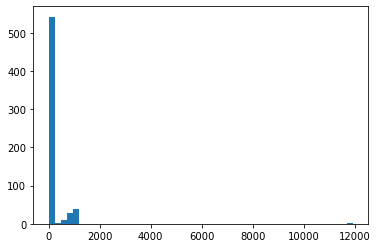

In [6]:
kras_cnt = variant_meta_kras['variant'].value_counts()
plt.hist(kras_cnt, bins = 50)

(array([719.,   3.,  19.,  18.,  44.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([1.0000e+00, 2.3600e+02, 4.7100e+02, 7.0600e+02, 9.4100e+02,
        1.1760e+03, 1.4110e+03, 1.6460e+03, 1.8810e+03, 2.1160e+03,
        2.3510e+03, 2.5860e+03, 2.8210e+03, 3.0560e+03, 3.2910e+03,
        3.5260e+03, 3.7610e+03, 3.9960e+03, 4.2310e+03, 4.4660e+03,
        4.7010e+03, 4.9360e+03, 5.1710e+03, 5.4060e+03, 5.6410e+03,
        5.8760e+03, 6.1110e+03, 6.3460e+03, 6.5810e+03, 6.8160e+03,
        7.0510e+03, 7.2860e+03, 7.5210e+03, 7.7560e+03, 7.9910e+03,
        8.2260e+03, 8.4610e+03, 8.6960e+03, 8.9310e+03, 9.1660e+03,
        9.4010e+03, 9.6360e+03, 9.8710e+03, 1.0106e+04, 1.0341e+04,
        1.0576e+04, 1.0811e+04, 1.1046e+04, 1.

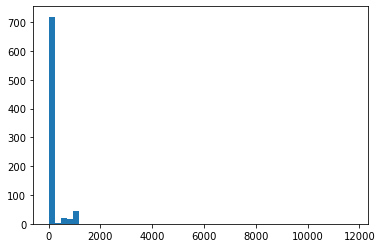

In [7]:
tp53_cnt = variant_meta_tp53['variant'].value_counts()
plt.hist(tp53_cnt, bins = 50)

(array([9.0000e+00, 8.2618e+04, 7.6200e+02, 0.0000e+00, 6.3000e+01,
        1.0000e+01, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([0. , 0.7, 1.4, 2.1, 2.8, 3.5, 4.2, 4.9, 5.6, 6.3, 7. ]),
 <a list of 10 Patch objects>)

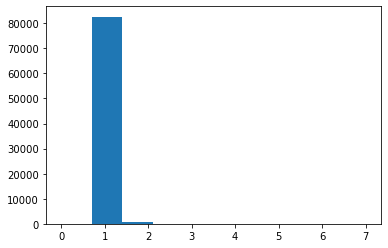

In [45]:
plt.hist((variant_meta_kras.iloc[:, 2:-3] > 0).sum(1))

In [49]:
(variant_meta_kras.iloc[:, 2:-3] > 0).sum(1).max()

7

(array([7.0000e+00, 8.3422e+04, 7.8800e+02, 1.4900e+02, 0.0000e+00,
        3.4000e+01, 3.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. , 4.8, 5.6, 6.4, 7.2, 8. ]),
 <a list of 10 Patch objects>)

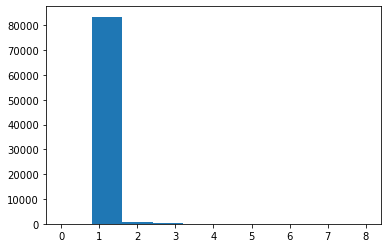

In [46]:
plt.hist((variant_meta_tp53.iloc[:, 2:-3] > 0).sum(1))

In [12]:
kras_variants = variant_meta_kras['variant'].unique()
tp53_variants = variant_meta_tp53['variant'].unique()

In [13]:
kras_variants.shape

(623,)

In [14]:
kras_variants[0]

'MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVIDGETCLLDILDTAGHEEYSAMRDQYMRTGEGFLCVFAINNTKSFEDIHHYREQIKRVKDSEDVPMVLVGNKCDLPSRTVDTKQAQDLARSYGIPFIETSAKTRQRVEDAFYTLVREIRQYRLKKISKEEKTPGCVKIKKCIIM'

In [15]:
data2 = []
for i in range(len(kras_variants)):
    data2.append(('protein_' + str(i + 1), kras_variants[i]))

    
for i in range(len(tp53_variants)):
    data2.append(('protein_' + str(i + 1 + len(kras_variants)), tp53_variants[i]))


In [16]:
len(data2)

1427

In [17]:
32 * 45

1440

In [18]:
batch_size = 32

In [42]:
sequence_representations = None
for k in range(len(data2) // batch_size + 1):
    start = k * batch_size
    end = min(start + batch_size, len(data2))
    batch_data = data2[start:end]
    
    batch_labels, batch_strs, batch_tokens = batch_converter(batch_data)
    
    # Extract per-residue representations (on CPU)
    with torch.no_grad():
        results = model(batch_tokens, repr_layers=[33], return_contacts=True)
    token_representations = results["representations"][33]

    # Generate per-sequence representations via averaging
    # NOTE: token 0 is always a beginning-of-sequence token, so the first residue is token 1.    
    for i, (_, seq) in enumerate(batch_data):
        if sequence_representations is None:
            sequence_representations = token_representations[i, 1 : len(seq) + 1].mean(0).numpy().reshape(1, -1)
        else:
            sequence_representations = np.concatenate((sequence_representations, 
                                                       token_representations[i, 1 : len(seq) + 1].mean(0).numpy().reshape(1, -1)
                                                      ), axis = 0)
            
    if k % 10 == 0:
        print(k)
        

0
10
20


KeyboardInterrupt: 

In [44]:
sequence_representations.shape

(832, 1280)

In [47]:
np.save('sequence_representation.npy', sequence_representations)

In [19]:
sequence_representations = np.load('sequence_representation.npy')

In [20]:
sequence_representations.shape

(832, 1280)

In [21]:
len(data2)

1427

In [22]:
(len(data2) - 832) // batch_size

18

In [23]:
(len(data2) - 832), 18 * batch_size

(595, 576)

In [24]:
for k in range( (len(data2) - 832) // batch_size + 1):
    start = k * batch_size + 832
    end = min(start + batch_size, len(data2))
    batch_data = data2[start:end]
    
    batch_labels, batch_strs, batch_tokens = batch_converter(batch_data)
    
    # Extract per-residue representations (on CPU)
    with torch.no_grad():
        results = model(batch_tokens, repr_layers=[33], return_contacts=True)
    token_representations = results["representations"][33]

    # Generate per-sequence representations via averaging
    # NOTE: token 0 is always a beginning-of-sequence token, so the first residue is token 1.    
    for i, (_, seq) in enumerate(batch_data):
        if sequence_representations is None:
            sequence_representations = token_representations[i, 1 : len(seq) + 1].mean(0).numpy().reshape(1, -1)
        else:
            sequence_representations = np.concatenate((sequence_representations, 
                                                       token_representations[i, 1 : len(seq) + 1].mean(0).numpy().reshape(1, -1)
                                                      ), axis = 0)
            
    if k % 10 == 0:
        print(k)
        

0
10


In [26]:
sequence_representations.shape

(1427, 1280)

In [27]:
np.save('sequence_representation.npy', sequence_representations)

In [32]:
pd.DataFrame(sequence_representations).drop_duplicates().shape

(1427, 1280)

In [ ]:
variant = []
for i in range(len(kras_variants)):
    data2.append(kras_variants[i])

    
for i in range(len(tp53_variants)):
    data2.append(('protein_' + str(i + 1 + len(kras_variants)), tp53_variants[i]))


In [36]:
sequence_data = pd.DataFrame(sequence_representations)
sequence_data.head()

,0,1,2,3,4,5,6,7,8,9,...,1270,1271,1272,1273,1274,1275,1276,1277,1278,1279
0,-0.265423,0.179650,-0.225785,-0.206642,-0.557859,0.119581,-0.287248,0.081718,0.058713,-0.099760,...,-0.195618,-0.041049,0.134037,-0.130913,0.242763,0.073181,0.269573,-0.407178,-0.071867,-0.065996
1,-0.278144,0.181181,-0.236613,-0.208591,-0.564084,0.133692,-0.290223,0.081900,0.060810,-0.100856,...,-0.218036,-0.053969,0.141021,-0.133544,0.242172,0.066834,0.281539,-0.411984,-0.071758,-0.066045
2,-0.282699,0.178889,-0.237082,-0.213134,-0.572183,0.144764,-0.294190,0.077246,0.061645,-0.102342,...,-0.211611,-0.034461,0.125952,-0.119197,0.248505,0.069867,0.274083,-0.406162,-0.086765,-0.077086
3,-0.274277,0.178795,-0.231165,-0.211761,-0.587401,0.136307,-0.291348,0.087265,0.062807,-0.101906,...,-0.210526,-0.045400,0.129757,-0.133592,0.238058,0.063792,0.278581,-0.408356,-0.065943,-0.066657
4,-0.271654,0.196492,-0.213158,-0.222259,-0.568875,0.135774,-0.280550,0.080816,0.062705,-0.091627,...,-0.199520,-0.033723,0.122324,-0.132439,0.236899,0.067788,0.260333,-0.409215,-0.063052,-0.064655


In [37]:
sequence_data['Variant'] = np.concatenate((kras_variants, tp53_variants))
sequence_data['Dataset'] = ['KRAS'] * kras_variants.shape[0] + ['TP53'] * tp53_variants.shape[0]
sequence_data.head()

,0,1,2,3,4,5,6,7,8,9,...,1272,1273,1274,1275,1276,1277,1278,1279,Variant,Dataset
0,-0.265423,0.179650,-0.225785,-0.206642,-0.557859,0.119581,-0.287248,0.081718,0.058713,-0.099760,...,0.134037,-0.130913,0.242763,0.073181,0.269573,-0.407178,-0.071867,-0.065996,MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...,KRAS
1,-0.278144,0.181181,-0.236613,-0.208591,-0.564084,0.133692,-0.290223,0.081900,0.060810,-0.100856,...,0.141021,-0.133544,0.242172,0.066834,0.281539,-0.411984,-0.071758,-0.066045,MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...,KRAS
2,-0.282699,0.178889,-0.237082,-0.213134,-0.572183,0.144764,-0.294190,0.077246,0.061645,-0.102342,...,0.125952,-0.119197,0.248505,0.069867,0.274083,-0.406162,-0.086765,-0.077086,MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...,KRAS
3,-0.274277,0.178795,-0.231165,-0.211761,-0.587401,0.136307,-0.291348,0.087265,0.062807,-0.101906,...,0.129757,-0.133592,0.238058,0.063792,0.278581,-0.408356,-0.065943,-0.066657,MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...,KRAS
4,-0.271654,0.196492,-0.213158,-0.222259,-0.568875,0.135774,-0.280550,0.080816,0.062705,-0.091627,...,0.122324,-0.132439,0.236899,0.067788,0.260333,-0.409215,-0.063052,-0.064655,MTEYKLVVVGAGGLGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...,KRAS


In [129]:
sequence_data = pd.read_csv('sequence_representation.csv')
sequence_data.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,1272,1273,1274,1275,1276,1277,1278,1279,Variant,Dataset
0,0,-0.265423,0.179650,-0.225785,-0.206642,-0.557859,0.119581,-0.287248,0.081718,0.058713,...,0.134037,-0.130913,0.242763,0.073181,0.269573,-0.407178,-0.071867,-0.065996,MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...,KRAS
1,1,-0.278144,0.181181,-0.236613,-0.208591,-0.564084,0.133692,-0.290223,0.081900,0.060810,...,0.141021,-0.133544,0.242172,0.066834,0.281539,-0.411984,-0.071758,-0.066045,MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...,KRAS
2,2,-0.282699,0.178889,-0.237082,-0.213134,-0.572183,0.144764,-0.294190,0.077246,0.061645,...,0.125952,-0.119197,0.248505,0.069867,0.274083,-0.406162,-0.086765,-0.077086,MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...,KRAS
3,3,-0.274277,0.178795,-0.231165,-0.211761,-0.587401,0.136307,-0.291348,0.087265,0.062807,...,0.129757,-0.133592,0.238058,0.063792,0.278581,-0.408356,-0.065943,-0.066657,MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...,KRAS
4,4,-0.271654,0.196492,-0.213158,-0.222259,-0.568875,0.135774,-0.280550,0.080816,0.062705,...,0.122324,-0.132439,0.236899,0.067788,0.260333,-0.409215,-0.063052,-0.064655,MTEYKLVVVGAGGLGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...,KRAS


In [40]:
data1 = pd.read_excel('41587_2021_1160_MOESM3_ESM.xlsx', sheet_name = 'KRAS')
data1.head()

,Gene,Variant,Position,From,To,Mutation type,Control status,Library synthesis,Variant barcode,Cells/variant,Normalized variant barcode counts (TP10K),HotellingT2,HotellingT2.q,Variant functional class,Count_pancan,Count_ExAC,Count (COSMIC)
0,KRAS,G12D,12.0,C,T,Single,unknown,in,CTCAGCGAAGAGAA,496.0,1.440787,6951.69426,0.00001,Impactful IV (gain-of-function),1782.0,NaN,14489.0
1,KRAS,G12V,12.0,C,A,Single,unknown,in,TCCTGACAAGAGAA,406.0,1.456876,5032.27397,0.00001,Impactful IV (gain-of-function),1539.0,NaN,9830.0
2,KRAS,G12C,12.0,C,A,Single,unknown,in,CTACAGCAAGAGAA,769.0,1.725312,5284.76726,0.00001,Impactful IV (gain-of-function),1110.0,NaN,4792.0
3,KRAS,G13D,13.0,C,T,Single,unknown,not in library,ATGCCAAGAGAGAA,NaN,NaN,NaN,NaN,unavailable,582.0,NaN,5452.0
4,KRAS,G12A,12.0,C,G,Single,unknown,in,AAGACGCAAGAGAA,913.0,1.880001,5014.76689,0.00001,Impactful IV (gain-of-function),353.0,NaN,2297.0


In [86]:
exdata = pd.read_csv('GSE161824_A549_KRAS_processed.expr.csv.gz', compression = 'gzip')
variant_meta_kras = pd.read_csv('variant_kras.csv')
variant_meta_tp53 = pd.read_csv('variant_tp53.csv')


In [106]:
exdata = pd.read_csv('GSE161824_A549_KRAS_processed.expr.csv.gz', compression = 'gzip')
exdata.shape

(90262, 1146)

In [87]:
variant_meta_kras.head()

,Unnamed: 0,Unnamed: 0.1,G60S,G60D,G13C,P34R,G13E,N26Y,Q61P,K147T,...,T20M,G77A,Q61K,S136N,V14L,R149K,Y166H,cell,batch,variant
0,0,AGAATAGCAAAGGTGCch1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,AGAATAGCAAAGGTGCch1,1,MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...
1,1,AGGGTGAAGCTCTCGGch1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,AGGGTGAAGCTCTCGGch1,1,MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...
2,2,CAAGAAAAGACAAGCCch1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CAAGAAAAGACAAGCCch1,1,MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...
3,3,CTACGTCAGTGGAGAAch1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CTACGTCAGTGGAGAAch1,1,MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...
4,4,CTGAAGTGTAAAGGAGch1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CTGAAGTGTAAAGGAGch1,1,MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...


In [89]:
exdata.head()

,Unnamed: 0,SAMD11,HES4,ISG15,ERRFI1,ENO1,EFHD2,EPHA2,UBR4,CAMK2N1,...,GTSE1,CTA-29F11.1,CCT8,EVA1C,CBR3,TFF1,PDXK,MT-ND1,MT-ATP6,MT-ND6
0,AGAATAGCAAAGGTGCch1,-0.475639,-0.603496,-0.326901,0.082439,-1.849039,0.820450,-0.527545,0.685223,1.212849,...,-0.966461,0.572137,-0.606646,-0.596926,-0.537216,4.060974,-1.745349,-2.605345,0.718420,-0.314252
1,AGGGTGAAGCTCTCGGch1,-0.464881,0.270650,-0.362514,0.129428,-0.327838,-0.649362,-0.692366,0.577036,-0.864933,...,0.880348,-0.395378,0.213405,1.830761,-0.508915,-0.274453,-0.667094,0.063176,-0.050541,0.365292
2,CAAGAAAAGACAAGCCch1,-0.466140,0.672429,-0.309800,0.354398,0.063893,-0.346248,-0.472002,-0.520825,-0.785602,...,-0.769988,-0.604668,-1.349746,-0.598015,-0.487766,-0.257752,-1.671023,-0.418839,-0.545874,0.044365
3,CTACGTCAGTGGAGAAch1,-0.451495,-0.654517,-0.336792,-0.738492,-0.947742,-1.294227,1.326682,1.389035,2.030581,...,-0.681636,-0.750243,0.369838,1.632521,-0.452601,-0.268676,0.043232,-0.216571,0.755075,-0.264658
4,CTGAAGTGTAAAGGAGch1,-0.450684,-0.622883,2.262108,-0.775162,-1.297039,-0.276864,-0.612407,-0.598665,-0.878863,...,-0.693941,-0.669953,0.818721,0.473520,-0.436037,-0.272547,1.035861,0.063702,0.859067,0.828217


In [92]:
exdata.merge(variant_meta_kras.loc[:, ['cell']], left_on = 'Unnamed: 0', right_on = 'cell', how = 'inner')

,Unnamed: 0,SAMD11,HES4,ISG15,ERRFI1,ENO1,EFHD2,EPHA2,UBR4,CAMK2N1,...,CTA-29F11.1,CCT8,EVA1C,CBR3,TFF1,PDXK,MT-ND1,MT-ATP6,MT-ND6,cell
0,AGAATAGCAAAGGTGCch1,-0.475639,-0.603496,-0.326901,0.082439,-1.849039,0.820450,-0.527545,0.685223,1.212849,...,0.572137,-0.606646,-0.596926,-0.537216,4.060974,-1.745349,-2.605345,0.718420,-0.314252,AGAATAGCAAAGGTGCch1
1,AGGGTGAAGCTCTCGGch1,-0.464881,0.270650,-0.362514,0.129428,-0.327838,-0.649362,-0.692366,0.577036,-0.864933,...,-0.395378,0.213405,1.830761,-0.508915,-0.274453,-0.667094,0.063176,-0.050541,0.365292,AGGGTGAAGCTCTCGGch1
2,CAAGAAAAGACAAGCCch1,-0.466140,0.672429,-0.309800,0.354398,0.063893,-0.346248,-0.472002,-0.520825,-0.785602,...,-0.604668,-1.349746,-0.598015,-0.487766,-0.257752,-1.671023,-0.418839,-0.545874,0.044365,CAAGAAAAGACAAGCCch1
3,CTACGTCAGTGGAGAAch1,-0.451495,-0.654517,-0.336792,-0.738492,-0.947742,-1.294227,1.326682,1.389035,2.030581,...,-0.750243,0.369838,1.632521,-0.452601,-0.268676,0.043232,-0.216571,0.755075,-0.264658,CTACGTCAGTGGAGAAch1
4,CTGAAGTGTAAAGGAGch1,-0.450684,-0.622883,2.262108,-0.775162,-1.297039,-0.276864,-0.612407,-0.598665,-0.878863,...,-0.669953,0.818721,0.473520,-0.436037,-0.272547,1.035861,0.063702,0.859067,0.828217,CTGAAGTGTAAAGGAGch1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83459,CTCGGAGCATTACGACch27,-0.460096,-0.732845,-0.325418,-0.821978,-0.264735,1.784411,-0.555070,-0.529916,0.127074,...,-0.626681,-1.100087,1.411236,-0.546219,-0.259655,0.285879,0.199043,0.112199,0.275879,CTCGGAGCATTACGACch27
83460,ATTTCTGGTGCACGAAch17,-0.463910,1.871283,-0.378137,-0.718904,-0.179987,-0.157484,-0.778209,-0.716193,-1.064706,...,-0.749123,0.560007,0.502174,-0.432852,-0.291441,-0.038603,-0.335362,0.230277,-2.566353,ATTTCTGGTGCACGAAch17
83461,CGGGTCACAGGACCCTch4,-0.489793,-0.738467,2.254487,0.571291,-0.892248,0.362815,2.305115,1.155793,-0.761426,...,0.685055,-1.217619,-0.746938,1.141839,-0.233985,0.567262,-0.474681,0.769507,-1.726508,CGGGTCACAGGACCCTch4
83462,GATGCTACAAGTCTGTch8,-0.453692,-0.596447,-0.329854,1.022562,0.095281,0.072901,-0.496861,1.694022,0.753764,...,-0.770148,1.419300,-0.672634,1.754622,-0.266899,0.279673,-0.565729,0.653258,0.450653,GATGCTACAAGTCTGTch8


In [104]:
exdata = pd.read_csv('GSE161824_A549_TP53_processed.expr.csv.gz', compression = 'gzip')


In [105]:
exdata.shape

(85778, 1225)

In [96]:
exdata.merge(variant_meta_tp53.loc[:, ['cell', 'variant']], left_on = 'Unnamed: 0', right_on = 'cell', how = 'inner')

,Unnamed: 0,SAMD11,HES4,ISG15,TMEM52,ERRFI1,ENO1,FBXO2,EFHD2,IFFO2,...,CBR3,ETS2,TFF1,PDXK,COL18A1,MT-ND1,MT-ND5,MT-ND6,cell,variant
0,ACGCCGATCAGGATCTch1,-0.776170,0.589083,0.717966,2.877892,0.134185,1.540157,-0.429501,-0.414267,-0.340909,...,0.127590,-0.471229,-0.262787,0.064165,0.189328,-0.943839,-0.139684,-0.971230,ACGCCGATCAGGATCTch1,MEEPQSDPSVEPPLSQETFSDLWKLLPENNVLSPLPSQAMDDLMLS...
1,ACGGAGATCCAGAAGGch1,-0.739876,-0.987964,1.626318,-0.172540,-0.890686,0.084106,-0.319378,0.311188,-0.389782,...,0.803553,-0.428994,-0.272774,1.686312,0.821127,0.251328,1.009668,1.285926,ACGGAGATCCAGAAGGch1,MEEPQSDPSVEPPLSQETFSDLWKLLPENNVLSPLPSQAMDDLMLS...
2,AGACGTTGTGTGCGTCch1,0.444238,0.030384,-0.422248,-0.166168,-0.889055,-0.201574,-0.292907,-0.244205,-0.377109,...,-0.550666,-0.415591,-0.269836,-1.078666,-0.649425,-0.317916,0.247160,-1.096434,AGACGTTGTGTGCGTCch1,MEEPQSDPSVEPPLSQETFSDLWKLLPENNVLSPLPSQAMDDLMLS...
3,CAGCATAGTATCAGTCch1,-0.737975,1.583419,-0.391185,-0.159248,-0.877025,-1.196377,-0.248098,-0.087603,-0.375388,...,-0.548799,-0.396203,3.239994,-0.264580,-0.607331,0.414912,0.568565,0.315088,CAGCATAGTATCAGTCch1,MEEPQSDPSVEPPLSQETFSDLWKLLPENNVLSPLPSQAMDDLMLS...
4,CGCCAAGTCATATCGGch1,0.325918,-0.062550,-0.406869,-0.159626,0.122657,0.176422,-0.256831,-0.362216,-0.343618,...,-0.609444,-0.396340,-0.260427,1.300730,-0.564829,-0.157129,-0.075755,1.123576,CGCCAAGTCATATCGGch1,MEEPQSDPSVEPPLSQETFSDLWKLLPENNVLSPLPSQAMDDLMLS...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84402,TACACGAAGGCACATGch32,2.165159,-0.796491,-0.377363,-0.144296,-0.813191,0.008649,-0.256820,0.320419,-0.270316,...,-0.465968,-0.382575,-0.263909,-0.600348,-0.565449,0.752786,-0.007943,-0.617621,TACACGAAGGCACATGch32,MEEPQSDPSVEPPLSQETFSDLWKLLPENNVLSPLPSQAMDDLMLS...
84403,TAGGCATTCCACGAATch32,2.074657,-0.687721,-0.403882,-0.137830,-0.835549,-0.156971,-0.277033,-0.983369,-0.224256,...,-0.416991,-0.383357,-0.257193,0.677340,-0.467666,-0.650890,0.569623,0.883707,TAGGCATTCCACGAATch32,MEEPQSDPSVEPPLSQETFSDLWKLLPENNVLSPLPSQAMDDLMLS...
84404,TGAGAGGCATGGTCTAch32,-0.690956,1.213572,-0.354700,-0.147827,-0.847792,0.252428,-0.230145,1.526483,-0.287664,...,-0.549966,-0.375420,-0.263821,0.500890,-0.606565,0.983831,-1.118967,-0.923008,TGAGAGGCATGGTCTAch32,MEEPQSDPSVEPPLSQETFSDLWKLLPENNVLSPLPSQAMDDLMLS...
84405,TGGCGCATCAGTACGTch32,-0.654200,-0.716424,-0.397153,-0.136783,0.628968,0.350733,-0.263050,-1.019534,-0.214707,...,-0.456682,-0.376734,-0.253691,-0.740468,-0.447552,1.116888,-1.324116,-0.566267,TGGCGCATCAGTACGTch32,MEEPQSDPSVEPPLSQETFSDLWKLLPENNVLSPLPSQAMDDLMLS...


In [82]:
kras_variants.shape, tp53_variants.shape

((623,), (804,))

In [83]:
idx_kras_remove = np.random.choice(kras_variants.shape[0], 60, replace= False)
idx_tp53_remove = np.random.choice(tp53_variants.shape[0], 80, replace= False)


In [85]:
np.save('removed_per_kras_60.npy', kras_variants[idx_kras_remove])
np.save('removed_per_tp53_80.npy', tp53_variants[idx_tp53_remove])

In [1]:
86935 + 77996 == 164931

True

(array([1.276e+03, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([6.3009677e-05, 2.3591450e-01, 4.7176600e-01, 7.0761752e-01,
        9.4346899e-01, 1.1793205e+00, 1.4151720e+00, 1.6510235e+00,
        1.8868750e+00, 2.1227264e+00, 2.3585780e+00], dtype=float32),
 <a list of 10 Patch objects>)

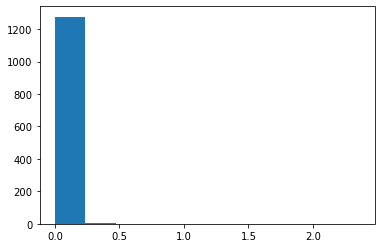

In [52]:
plt.hist(sequence_data.iloc[:, :-2].var(0))

In [54]:
from sklearn.decomposition import PCA
pca_50 = PCA(n_components=50, random_state = 42)
pca_data = pca_50.fit_transform(sequence_data.iloc[:, :-2])


In [58]:
from plotnine import * 

In [56]:
X_embedded_pr = umap.UMAP(random_state=42, min_dist = 0.5, n_neighbors=30).fit_transform(pca_data)
df_tsne_pr = X_embedded_pr.copy()
df_tsne_pr = pd.DataFrame(df_tsne_pr)
df_tsne_pr['x-umap'] = X_embedded_pr[:,0]
df_tsne_pr['y-umap'] = X_embedded_pr[:,1]
df_tsne_pr['category'] = sequence_data['Dataset']

/home/hengshi/.local/lib/python3.8/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/hengshi/.local/lib/python3.8/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


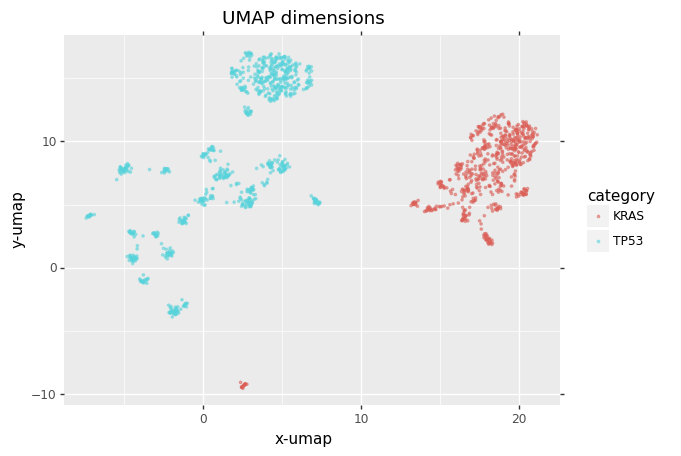

<ggplot: (2993961235204)>

In [59]:
chart_pr = ggplot(df_tsne_pr, aes(x= 'x-umap', y= 'y-umap', colour = 'category') ) \
    + geom_point(size=0.5, alpha = 0.5) \
    + ggtitle("UMAP dimensions")
chart_pr

(array([1.215e+03, 5.000e+01, 7.000e+00, 4.000e+00, 0.000e+00, 2.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([6.3009677e-05, 4.7233310e-02, 9.4403610e-02, 1.4157391e-01,
        1.8874420e-01, 2.3591450e-01, 2.8308481e-01, 3.3025509e-01,
        3.7742540e-01, 4.2459571e-01, 4.7176600e-01, 5.1893628e-01,
        5.6610662e-01, 6.1327690e-01, 6.6044718e-01, 7.0761752e-01,
        7.5478780e-01, 8.0195808e-01, 8.4912837e-01, 8.9629871e-01,
        9.4346899e-01, 9.9063927e-01

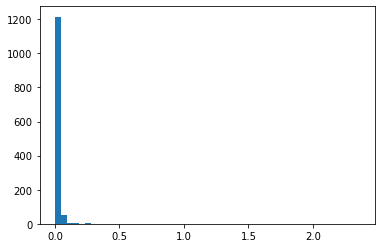

In [61]:
plt.hist(sequence_data.iloc[:, :-2].var(0), bins = 50)

In [63]:
sequence_data.iloc[:, :-2].var(0).min(), sequence_data.iloc[:, :-2].var(0).max()

(6.300967652350664e-05, 2.3585779666900635)

In [81]:
(sequence_data.iloc[:, :-2].var(0) >= 0.001).mean()

0.7984375

/home/hengshi/.local/lib/python3.8/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/hengshi/.local/lib/python3.8/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


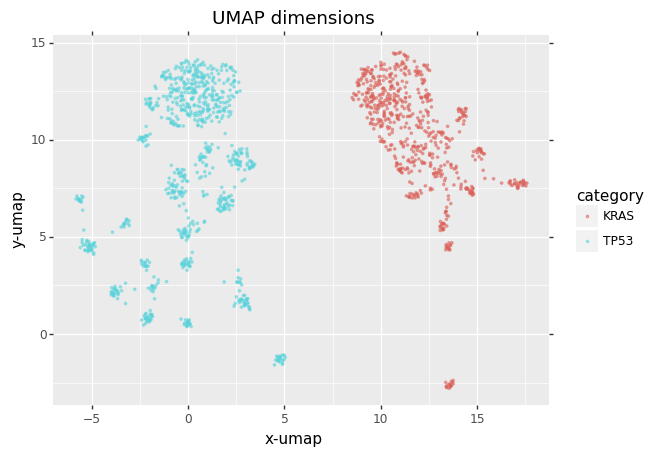

<ggplot: (2994047969121)>

In [69]:
pca_50 = PCA(n_components=50, random_state = 42)
pca_data = pca_50.fit_transform(sequence_data.iloc[:, :-2].values + np.random.normal(scale = 0.01, size = sequence_data.iloc[:, :-2].shape))
X_embedded_pr = umap.UMAP(random_state=42, min_dist = 0.5, n_neighbors=30).fit_transform(pca_data)
df_tsne_pr = X_embedded_pr.copy()
df_tsne_pr = pd.DataFrame(df_tsne_pr)
df_tsne_pr['x-umap'] = X_embedded_pr[:,0]
df_tsne_pr['y-umap'] = X_embedded_pr[:,1]
df_tsne_pr['category'] = sequence_data['Dataset']

chart_pr = ggplot(df_tsne_pr, aes(x= 'x-umap', y= 'y-umap', colour = 'category') ) \
    + geom_point(size=0.5, alpha = 0.5) \
    + ggtitle("UMAP dimensions")
chart_pr

/home/hengshi/.local/lib/python3.8/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/hengshi/.local/lib/python3.8/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


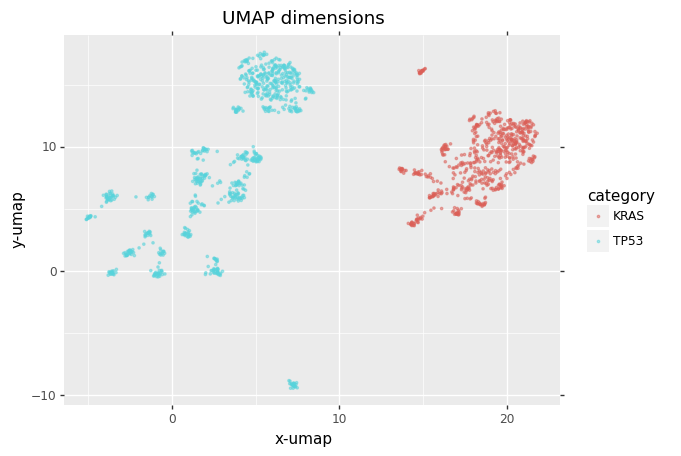

<ggplot: (2994048326373)>

In [70]:
pca_50 = PCA(n_components=50, random_state = 42)
pca_data = pca_50.fit_transform(sequence_data.iloc[:, :-2].values + np.random.normal(scale = 0.001, size = sequence_data.iloc[:, :-2].shape))
X_embedded_pr = umap.UMAP(random_state=42, min_dist = 0.5, n_neighbors=30).fit_transform(pca_data)
df_tsne_pr = X_embedded_pr.copy()
df_tsne_pr = pd.DataFrame(df_tsne_pr)
df_tsne_pr['x-umap'] = X_embedded_pr[:,0]
df_tsne_pr['y-umap'] = X_embedded_pr[:,1]
df_tsne_pr['category'] = sequence_data['Dataset']

chart_pr = ggplot(df_tsne_pr, aes(x= 'x-umap', y= 'y-umap', colour = 'category') ) \
    + geom_point(size=0.5, alpha = 0.5) \
    + ggtitle("UMAP dimensions")
chart_pr

/home/hengshi/.local/lib/python3.8/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/hengshi/.local/lib/python3.8/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


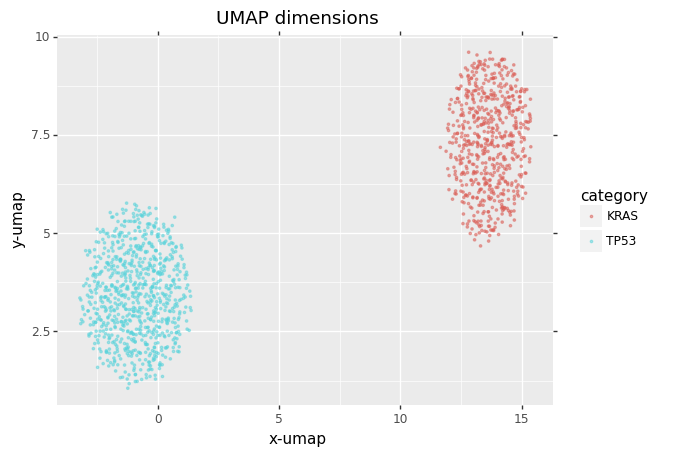

<ggplot: (2994048609308)>

In [71]:
pca_50 = PCA(n_components=50, random_state = 42)
pca_data = pca_50.fit_transform(sequence_data.iloc[:, :-2].values + np.random.normal(scale = 0.1, size = sequence_data.iloc[:, :-2].shape))
X_embedded_pr = umap.UMAP(random_state=42, min_dist = 0.5, n_neighbors=30).fit_transform(pca_data)
df_tsne_pr = X_embedded_pr.copy()
df_tsne_pr = pd.DataFrame(df_tsne_pr)
df_tsne_pr['x-umap'] = X_embedded_pr[:,0]
df_tsne_pr['y-umap'] = X_embedded_pr[:,1]
df_tsne_pr['category'] = sequence_data['Dataset']

chart_pr = ggplot(df_tsne_pr, aes(x= 'x-umap', y= 'y-umap', colour = 'category') ) \
    + geom_point(size=0.5, alpha = 0.5) \
    + ggtitle("UMAP dimensions")
chart_pr

/home/hengshi/.local/lib/python3.8/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/hengshi/.local/lib/python3.8/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


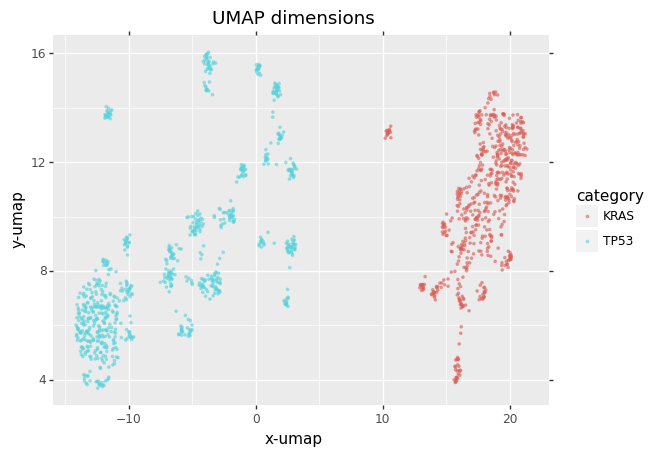

<ggplot: (2994047866917)>

In [72]:
pca_50 = PCA(n_components=50, random_state = 42)
pca_data = pca_50.fit_transform(sequence_data.iloc[:, :-2].values + np.random.normal(scale = 0.0001, size = sequence_data.iloc[:, :-2].shape))
X_embedded_pr = umap.UMAP(random_state=42, min_dist = 0.5, n_neighbors=30).fit_transform(pca_data)
df_tsne_pr = X_embedded_pr.copy()
df_tsne_pr = pd.DataFrame(df_tsne_pr)
df_tsne_pr['x-umap'] = X_embedded_pr[:,0]
df_tsne_pr['y-umap'] = X_embedded_pr[:,1]
df_tsne_pr['category'] = sequence_data['Dataset']

chart_pr = ggplot(df_tsne_pr, aes(x= 'x-umap', y= 'y-umap', colour = 'category') ) \
    + geom_point(size=0.5, alpha = 0.5) \
    + ggtitle("UMAP dimensions")
chart_pr

In [42]:
from esm import FastaBatchedDataset
data_all = FastaBatchedDataset.from_file('KRAS.fasta')

In [45]:
len(data_all)

1

In [46]:
batches = data_all.get_batch_indices(4096, extra_toks_per_seq = 1)

In [49]:
data_loader = torch.utils.data.DataLoader(
    data_all, collate_fn=alphabet.get_batch_converter(), batch_sampler=batches
    )

In [50]:
for i, data in enumerate(data_loader):
    print(i)

0


In [52]:
len(data)

3

In [53]:
data[0]

['sp|P01116|RASK_HUMAN GTPase KRas OS=Homo sapiens OX=9606 GN=KRAS PE=1 SV=1']

In [54]:
data[1]

['MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVIDGETCLLDILDTAGQEEYSAMRDQYMRTGEGFLCVFAINNTKSFEDIHHYREQIKRVKDSEDVPMVLVGNKCDLPSRTVDTKQAQDLARSYGIPFIETSAKTRQRVEDAFYTLVREIRQYRLKKISKEEKTPGCVKIKKCIIM']

In [55]:
data[2]

tensor([[ 0, 20, 11,  9, 19, 15,  4,  7,  7,  7,  6,  5,  6,  6,  7,  6, 15,  8,
          5,  4, 11, 12, 16,  4, 12, 16, 17, 21, 18,  7, 13,  9, 19, 13, 14, 11,
         12,  9, 13,  8, 19, 10, 15, 16,  7,  7, 12, 13,  6,  9, 11, 23,  4,  4,
         13, 12,  4, 13, 11,  5,  6, 16,  9,  9, 19,  8,  5, 20, 10, 13, 16, 19,
         20, 10, 11,  6,  9,  6, 18,  4, 23,  7, 18,  5, 12, 17, 17, 11, 15,  8,
         18,  9, 13, 12, 21, 21, 19, 10,  9, 16, 12, 15, 10,  7, 15, 13,  8,  9,
         13,  7, 14, 20,  7,  4,  7,  6, 17, 15, 23, 13,  4, 14,  8, 10, 11,  7,
         13, 11, 15, 16,  5, 16, 13,  4,  5, 10,  8, 19,  6, 12, 14, 18, 12,  9,
         11,  8,  5, 15, 11, 10, 16, 10,  7,  9, 13,  5, 18, 19, 11,  4,  7, 10,
          9, 12, 10, 16, 19, 10,  4, 15, 15, 12,  8, 15,  9,  9, 15, 11, 14,  6,
         23,  7, 15, 12, 15, 15, 23, 12, 12, 20,  2]])

In [29]:
variant.iloc[:10, :-2].values.sum(1)

array([ 4.,  1.,  1., 15.,  1.,  1.,  6.,  2.,  2.,  1.])

In [30]:
variant2 = pd.read_csv('GSE161824_A549_TP53_variant2cell.csv.gz', compression = 'gzip', sep = '\t')
variant2.head()

,V216V,P301P,Q5R,Y107H,A83V,R248L,H214R,P152L,V173L,R158R,...,R248W,C135F,R280K,K132N,G154V,S127F,Y220C,C275F,cell,batch
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ACGATGTGTCAACTGTch4,4
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ATTGGACTCGAGGTAGch16,16
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,GTCATTTCAATGTAAGch32,32
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,ACATGGTTCGCTTAGAch6,6
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,AGATCTGTCGCCTGAGch22,22


In [33]:
variant2.iloc[:10, :-2].values.sum(1)

array([7., 6., 1., 1., 3., 1., 1., 5., 1., 1.])

In [34]:
variant2.shape

(252759, 101)

In [35]:
variant2['batch'].unique().shape

(32,)

In [98]:
import os

In [99]:
path_data ='/nfs/turbo/umms-welchjd/hengshi/perturb_gan/data/protein_variant'

data_cell_kras = pd.read_csv(os.path.join(path_data, 'GSE161824_A549_KRAS_processed.expr.csv.gz'), compression = 'gzip')
data_cell_tp53 = pd.read_csv(os.path.join(path_data, 'GSE161824_A549_TP53_processed.expr.csv.gz'), compression = 'gzip')

data_variant_kras = pd.read_csv(os.path.join(path_data, 'variant_kras.csv'))
data_variant_tp53 = pd.read_csv(os.path.join(path_data, 'variant_tp53.csv'))

data_kras = data_cell_kras.merge(data_variant_kras.loc[:, ['cell']], left_on = 'Unnamed: 0', right_on = 'cell', how = 'inner').iloc[:, 1:-1].values
data_tp53 = data_cell_tp53.merge(data_variant_tp53.loc[:, ['cell']], left_on = 'Unnamed: 0', right_on = 'cell', how = 'inner').iloc[:, 1:-1].values

data_cell = np.concatenate((data_kras, data_tp53), axis = 0)

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 1145 and the array at index 1 has size 1224

In [120]:
data_kras = data_cell_kras.merge(data_variant_kras.loc[:, ['cell']], left_on = 'Unnamed: 0', right_on = 'cell', how = 'inner')
data_tp53 = data_cell_tp53.merge(data_variant_tp53.loc[:, ['cell']], left_on = 'Unnamed: 0', right_on = 'cell', how = 'inner')


In [124]:
gene_kras = np.array(list(data_kras.columns[1:-1]))
gene_tp53 = np.array(list(data_tp53.columns[1:-1]))
gene_common = np.array(list(set(gene_kras) & set(gene_tp53)))

In [126]:
shuffle_kras = [np.where(gene_kras == i)[0][0] for i in gene_common]
shuffle_tp53 = [np.where(gene_tp53 == i)[0][0] for i in gene_common]

In [112]:
data_kras

array([[-0.4756391 , -0.603496  , -0.3269006 , ..., -2.605345  ,
         0.7184196 , -0.3142518 ],
       [-0.46488112,  0.27065036, -0.36251444, ...,  0.06317574,
        -0.05054111,  0.3652922 ],
       [-0.46613953,  0.6724289 , -0.30979988, ..., -0.41883907,
        -0.545874  ,  0.04436458],
       ...,
       [-0.48979303, -0.7384667 ,  2.254487  , ..., -0.4746811 ,
         0.76950717, -1.7265078 ],
       [-0.45369187, -0.5964466 , -0.3298544 , ..., -0.5657291 ,
         0.6532582 ,  0.45065278],
       [-0.39688978, -0.41334403, -0.26688993, ...,  0.5448121 ,
         0.96922445,  0.11468673]])

In [127]:
data_kras = data_kras.iloc[:, 1:-1].values[:, shuffle_kras]
data_tp53 = data_tp53.iloc[:, 1:-1].values[:, shuffle_tp53]

data_cell = np.concatenate((data_kras, data_tp53), axis = 0)

In [128]:
data_cell.shape

(167871, 939)

In [4]:
removed_kras = np.load(os.path.join('.', 'removed_per_kras_60.npy'), allow_pickle=True)
removed_tp53 = np.load(os.path.join('.', 'removed_per_tp53_80.npy'), allow_pickle=True)

NameError: name 'np' is not defined

In [2]:
import torch

In [4]:
a = torch.normal(mean = 0, std = 0.001, size = (100, 2))

In [9]:
a.shape[0]

100

In [11]:
import numpy as np

In [13]:
np.random.normal(scale = 0.001, size = a.shape).shape

(100, 2)

# Filter data by number of cells per perturbation

In [11]:
# UMAP of the data
import pandas as pd
import numpy as np
import umap
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
import os
import torch


In [2]:
pwd

'/nfs/turbo/umms-welchjd/hengshi/perturb_gan/data/protein_variant'

In [3]:
variant_meta_kras = pd.read_csv('variant_kras.csv')
variant_meta_tp53 = pd.read_csv('variant_tp53.csv')

(array([542.,   1.,  11.,  28.,  40.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([1.000000e+00, 2.395800e+02, 4.781600e+02, 7.167400e+02,
        9.553200e+02, 1.193900e+03, 1.432480e+03, 1.671060e+03,
        1.909640e+03, 2.148220e+03, 2.386800e+03, 2.625380e+03,
        2.863960e+03, 3.102540e+03, 3.341120e+03, 3.579700e+03,
        3.818280e+03, 4.056860e+03, 4.295440e+03, 4.534020e+03,
        4.772600e+03, 5.011180e+03, 5.249760e+03, 5.488340e+03,
        5.726920e+03, 5.965500e+03, 6.204080e+03, 6.442660e+03,
        6.681240e+03, 6.919820e+03, 7.158400e+03, 7.396980e+03,
        7.635560e+03, 7.874140e+03, 8.112720e+03, 8.351300e+03,
        8.589880e+03, 8.828460e+03, 9.067040e+03, 9.305620e+03,
        9.544200e+

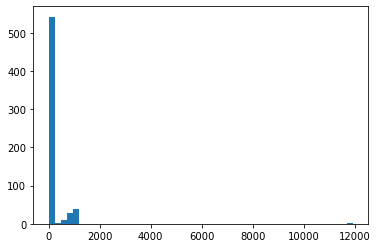

In [4]:
kras_cnt = variant_meta_kras['variant'].value_counts()
plt.hist(kras_cnt, bins = 50)

In [5]:
tp53_cnt = variant_meta_tp53['variant'].value_counts()

In [6]:
def quantiles(a,  quantile_list = [0, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99, 1]):
   
    quantiles = []
    for q in quantile_list:
        quantiles.append(np.quantile(a, q))
    return quantiles

In [7]:
quantiles(kras_cnt)

[1, 1.0, 1.0, 1.0, 1.0, 769.0000000000003, 1004.0, 11930]

In [8]:
quantiles(tp53_cnt)

[1, 1.0, 1.0, 1.0, 1.0, 488.70000000000095, 1004.0, 11751]

In [9]:
(kras_cnt > 1).mean(), kras_cnt.shape

(0.23595505617977527, (623,))

In [10]:
(tp53_cnt > 1).mean(), tp53_cnt.shape

(0.20398009950248755, (804,))

In [11]:
kras_cnt.shape

(623,)

In [12]:
quantiles(kras_cnt,  quantile_list = [0.8, 0.85, 0.88, 0.89, 0.9, 0.99, 1])

[2.0,
 2.0,
 634.5200000000001,
 714.3800000000005,
 769.0000000000003,
 1004.0,
 11930]

In [13]:
quantiles(tp53_cnt,  quantile_list = [0.8, 0.85, 0.88, 0.89, 0.9, 0.99, 1])

[2.0, 2.0, 2.0, 2.669999999999959, 488.70000000000095, 1004.0, 11751]

In [14]:
(kras_cnt > 400).mean(), (tp53_cnt > 400).mean()

(0.13001605136436598, 0.1044776119402985)

In [15]:
kras_cnt[kras_cnt > 400].keys()

Index(['MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVIDGETCLLDILDTAGQEEYSAMRDQYMRTGEGFLCVFAINNTKSFEDIHHYREQIKRVKDSEDVPMVLVGNKCDLPSRTVDTKQAQDLARSYGIPFIETSAKTRQRVEDAFYTLVREIRQYRLKKISKEEKTPGCVKIKKCIIM',
       'MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVIDGETCLLDILDTAGQEEYSAMRDQYMRTGEGFLCVFAINNTKSFEDIHHYREQIKRVKDSEDVPMVLVGNKCDLPSRTVDTKQAQDLARSYGIPFIETSPKTRQRVEDAFYTLVREIRQYRLKKISKEEKTPGCVKIKKCIIM',
       'MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVIDGETCLLDILDTAGQEEYSAMSDQYMRTGEGFLCVFAINNTKSFEDIHHYREQIKRVKDSEDVPMVLVGNKCDLPSRTVDTKQAQDLARSYGIPFIETSAKTRQRVEDAFYTLVREIRQYRLKKISKEEKTPGCVKIKKCIIM',
       'MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVIDGETCLLDILDTGGQEEYSAMRDQYMRTGEGFLCVFAINNTKSFEDIHHYREQIKRVKDSEDVPMVLVGNKCDLPSRTVDTKQAQDLARSYGIPFIETSAKTRQRVEDAFYTLVREIRQYRLKKISKEEKTPGCVKIKKCIIM',
       'MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVIDGETCLLDILDTAGQEEYSAMRDQYMRTGEGFLCVFAINNTKSFEDIHHYREQIKRVKDSEDVPLVLVGNKCDLPSRTVDTKQAQDLARSYGIPFIETSAKTRQRVEDAFYTLVREIRQYRLKKISKEEKTPGCVKIKKCIIM',


In [20]:
# original sequence
removed_kras = np.load(os.path.join('.', 'removed_per_kras_60.npy'), allow_pickle=True)
removed_tp53 = np.load(os.path.join('.', 'removed_per_tp53_80.npy'), allow_pickle=True)

In [21]:
from esm import FastaBatchedDataset

data_all = FastaBatchedDataset.from_file('KRAS.fasta')
batches = data_all.get_batch_indices(4096, extra_toks_per_seq = 1)
data_loader = torch.utils.data.DataLoader(
    data_all, collate_fn=alphabet.get_batch_converter(), batch_sampler=batches
    )
for i, data in enumerate(data_loader):
    print(i)
base_protein_kras = data[1][0]
base_protein_kras

0


'MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVIDGETCLLDILDTAGQEEYSAMRDQYMRTGEGFLCVFAINNTKSFEDIHHYREQIKRVKDSEDVPMVLVGNKCDLPSRTVDTKQAQDLARSYGIPFIETSAKTRQRVEDAFYTLVREIRQYRLKKISKEEKTPGCVKIKKCIIM'

In [22]:
base_protein_kras in removed_kras

False

In [23]:
data_all = FastaBatchedDataset.from_file('TP53.fasta')
batches = data_all.get_batch_indices(4096, extra_toks_per_seq = 1)
data_loader = torch.utils.data.DataLoader(
    data_all, collate_fn=alphabet.get_batch_converter(), batch_sampler=batches
    )
for i, data in enumerate(data_loader):
    print(i)
base_protein_tp53 = data[1][0]
base_protein_tp53

0


'MEEPQSDPSVEPPLSQETFSDLWKLLPENNVLSPLPSQAMDDLMLSPDDIEQWFTEDPGPDEAPRMPEAAPPVAPAPAAPTPAAPAPAPSWPLSSSVPSQKTYQGSYGFRLGFLHSGTAKSVTCTYSPALNKMFCQLAKTCPVQLWVDSTPPPGTRVRAMAIYKQSQHMTEVVRRCPHHERCSDSDGLAPPQHLIRVEGNLRVEYLDDRNTFRHSVVVPYEPPEVGSDCTTIHYNYMCNSSCMGGMNRRPILTIITLEDSSGNLLGRNSFEVRVCACPGRDRRTEEENLRKKGEPHHELPPGSTKRALPNNTSSSPQPKKKPLDGEYFTLQIRGRERFEMFRELNEALELKDAQAGKEPGGSRAHSSHLKSKKGQSTSRHKKLMFKTEGPDSD'

In [24]:
base_protein_tp53 in removed_tp53 

False

In [25]:
(base_protein_kras == 'MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVIDGETCLLDILDTAGQEEYSAMRDQYMRTGEGFLCVFAINNTKSFEDIHHYREQIKRVKDSEDVPMVLVGNKCDLPSRTVDTKQAQDLARSYGIPFIETSAKTRQRVEDAFYTLVREIRQYRLKKISKEEKTPGCVKIKKCIIM'   , 
base_protein_tp53 == 'MEEPQSDPSVEPPLSQETFSDLWKLLPENNVLSPLPSQAMDDLMLSPDDIEQWFTEDPGPDEAPRMPEAAPPVAPAPAAPTPAAPAPAPSWPLSSSVPSQKTYQGSYGFRLGFLHSGTAKSVTCTYSPALNKMFCQLAKTCPVQLWVDSTPPPGTRVRAMAIYKQSQHMTEVVRRCPHHERCSDSDGLAPPQHLIRVEGNLRVEYLDDRNTFRHSVVVPYEPPEVGSDCTTIHYNYMCNSSCMGGMNRRPILTIITLEDSSGNLLGRNSFEVRVCACPGRDRRTEEENLRKKGEPHHELPPGSTKRALPNNTSSSPQPKKKPLDGEYFTLQIRGRERFEMFRELNEALELKDAQAGKEPGGSRAHSSHLKSKKGQSTSRHKKLMFKTEGPDSD' ) 

(True, True)

In [36]:
data_meta = pd.read_csv(os.path.join('.', 'sequence_representation.csv'))
trt_list = np.array(list(data_meta['Variant']))

In [37]:
data_meta['Variant'].shape, data_meta['Variant'].unique().shape

((1427,), (1427,))

# embedding of perturbations by class

In [13]:
sequence_data = pd.read_csv('sequence_representation.csv')
sequence_data.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,1272,1273,1274,1275,1276,1277,1278,1279,Variant,Dataset
0,0,-0.265423,0.179650,-0.225785,-0.206642,-0.557859,0.119581,-0.287248,0.081718,0.058713,...,0.134037,-0.130913,0.242763,0.073181,0.269573,-0.407178,-0.071867,-0.065996,MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...,KRAS
1,1,-0.278144,0.181181,-0.236613,-0.208591,-0.564084,0.133692,-0.290223,0.081900,0.060810,...,0.141021,-0.133544,0.242172,0.066834,0.281539,-0.411984,-0.071758,-0.066045,MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...,KRAS
2,2,-0.282699,0.178889,-0.237082,-0.213134,-0.572183,0.144764,-0.294190,0.077246,0.061645,...,0.125952,-0.119197,0.248505,0.069867,0.274083,-0.406162,-0.086765,-0.077086,MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...,KRAS
3,3,-0.274277,0.178795,-0.231165,-0.211761,-0.587401,0.136307,-0.291348,0.087265,0.062807,...,0.129757,-0.133592,0.238058,0.063792,0.278581,-0.408356,-0.065943,-0.066657,MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...,KRAS
4,4,-0.271654,0.196492,-0.213158,-0.222259,-0.568875,0.135774,-0.280550,0.080816,0.062705,...,0.122324,-0.132439,0.236899,0.067788,0.260333,-0.409215,-0.063052,-0.064655,MTEYKLVVVGAGGLGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...,KRAS


In [14]:
variant_meta_kras = pd.read_csv('variant_kras.csv')
variant_meta_tp53 = pd.read_csv('variant_tp53.csv')
variant_meta_kras.head()

,Unnamed: 0,Unnamed: 0.1,G60S,G60D,G13C,P34R,G13E,N26Y,Q61P,K147T,...,T20M,G77A,Q61K,S136N,V14L,R149K,Y166H,cell,batch,variant
0,0,AGAATAGCAAAGGTGCch1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,AGAATAGCAAAGGTGCch1,1,MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...
1,1,AGGGTGAAGCTCTCGGch1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,AGGGTGAAGCTCTCGGch1,1,MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...
2,2,CAAGAAAAGACAAGCCch1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CAAGAAAAGACAAGCCch1,1,MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...
3,3,CTACGTCAGTGGAGAAch1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CTACGTCAGTGGAGAAch1,1,MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...
4,4,CTGAAGTGTAAAGGAGch1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CTGAAGTGTAAAGGAGch1,1,MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...


In [46]:
variant_meta_kras.shape

(83464, 103)

In [47]:
(variant_meta_kras.iloc[:, 2:-3] > 0) * 1

,G60S,G60D,G13C,P34R,G13E,N26Y,Q61P,K147T,AG11TD,A146T,...,R68S,G12D,T158A,T20M,G77A,Q61K,S136N,V14L,R149K,Y166H
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83459,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
83460,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
83461,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
83462,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [48]:
variant_meta_kras_see = (variant_meta_kras.iloc[:, 2:-3] > 0) * 1
dropedVariant_kras = variant_meta_kras_see.drop_duplicates()
variant_meta_kras_see['variant'] = list(variant_meta_kras['variant'])
dropedVariant_kras_variant = variant_meta_kras_see.drop_duplicates()

dropedVariant_kras.shape, dropedVariant_kras_variant.shape

((831, 98), (831, 99))

In [49]:
variant_meta_kras_see['variant'].unique().shape

(623,)

In [50]:
idx_sne1 = list(variant_meta_kras_see.iloc[:, :-1].sum(1) <= 1)
idx_large1 = list(variant_meta_kras_see.iloc[:, :-1].sum(1) > 1)

In [51]:
variant_meta_kras_see.iloc[idx_sne1, :].drop_duplicates().shape

(93, 99)

In [52]:
variant_meta_kras_see.iloc[idx_sne1, :-1].drop_duplicates().shape

(93, 98)

In [53]:
dropedVariant_kras_variant.shape
idx_g1 = list(dropedVariant_kras_variant.iloc[:, :-1].sum(1) > 1)
idx_e1 = list(dropedVariant_kras_variant.iloc[:, :-1].sum(1) == 1)
idx_e0 =  list(dropedVariant_kras_variant.iloc[:, :-1].sum(1) == 0)
columns_choose = np.array(list(dropedVariant_kras_variant.columns)[:-1])
row, col = np.where(dropedVariant_kras_variant.iloc[idx_e1, :].iloc[:, :-1].values == 1)

In [54]:
np.sum(idx_e1)

92

In [80]:
new_data = pd.DataFrame({'Variant': ['unassigned'] * dropedVariant_kras_variant.shape[0], 
                         })
new_data['Variant'][idx_e1] = columns_choose[col]
new_data['Variant'][idx_g1] = 'Multiple'

In [81]:
dropedVariant_kras_variant.iloc[:, :-1].sum(1).max()

7

In [82]:
new_data['Sequence'] = list(dropedVariant_kras_variant['variant'])
new_data.head()

,Variant,Sequence
0,Q61H,MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...
1,T74T,MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...
2,Multiple,MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...
3,Multiple,MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...
4,Multiple,MTEYKLVVVGAGGLGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...


In [83]:
data1 = pd.read_excel('41587_2021_1160_MOESM3_ESM.xlsx', sheet_name = 'KRAS')
data1.head()

,Gene,Variant,Position,From,To,Mutation type,Control status,Library synthesis,Variant barcode,Cells/variant,Normalized variant barcode counts (TP10K),HotellingT2,HotellingT2.q,Variant functional class,Count_pancan,Count_ExAC,Count (COSMIC)
0,KRAS,G12D,12.0,C,T,Single,unknown,in,CTCAGCGAAGAGAA,496.0,1.440787,6951.69426,0.00001,Impactful IV (gain-of-function),1782.0,NaN,14489.0
1,KRAS,G12V,12.0,C,A,Single,unknown,in,TCCTGACAAGAGAA,406.0,1.456876,5032.27397,0.00001,Impactful IV (gain-of-function),1539.0,NaN,9830.0
2,KRAS,G12C,12.0,C,A,Single,unknown,in,CTACAGCAAGAGAA,769.0,1.725312,5284.76726,0.00001,Impactful IV (gain-of-function),1110.0,NaN,4792.0
3,KRAS,G13D,13.0,C,T,Single,unknown,not in library,ATGCCAAGAGAGAA,NaN,NaN,NaN,NaN,unavailable,582.0,NaN,5452.0
4,KRAS,G12A,12.0,C,G,Single,unknown,in,AAGACGCAAGAGAA,913.0,1.880001,5014.76689,0.00001,Impactful IV (gain-of-function),353.0,NaN,2297.0


In [84]:
new_data.shape

(831, 2)

In [85]:
new_data_merge = new_data.merge(data1.loc[:, ['Variant', 'Variant functional class']], left_on = 'Variant', right_on = 'Variant', how = "left")

In [86]:
new_data_merge.shape, new_data.shape

((831, 3), (831, 2))

In [87]:
new_data_merge['Variant functional class'].isna().sum()

738

In [89]:
new_data_merge[new_data_merge['Variant'] == 'Multiple']['Variant functional class'].isna().sum()

738

In [97]:
data1.tail()

,Gene,Variant,Position,From,To,Mutation type,Control status,Library synthesis,Variant barcode,Cells/variant,Normalized variant barcode counts (TP10K),HotellingT2,HotellingT2.q,Variant functional class,Count_pancan,Count_ExAC,Count (COSMIC)
97,KRAS,G12I,12.0,CC,AT,Multiple,unknown,in,CCAAGAAGAGAGAA,1100.0,1.688079,7577.673190,0.000010,Impactful IV (gain-of-function),2.0,NaN,7.0
98,KRAS,Q61P,61.0,A,G,Single,unknown,in,AGGTCATAGGAGAA,1119.0,1.188467,878.331272,0.000010,Impactful III,3.0,NaN,17.0
99,KRAS,K147N,147.0,C,G,Single,unknown,in,AGAGCCAACGAGAA,1019.0,1.363952,117.979667,0.000010,WT-like,2.0,NaN,2.0
100,KRAS,WT,NaN,NaN,NaN,NaN,synonymous,in,GCTACAGAAGAGAA,644.0,1.348324,32.809475,0.582764,WT-like,NaN,NaN,NaN
101,KRAS,unassigned,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34976.0,0.000000,411.459204,0.000010,Impactful II,NaN,NaN,NaN


In [96]:
new_data_merge[new_data_merge['Sequence'] ==  base_protein_kras]

,Variant,Sequence,Variant functional class
1,T74T,MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...,WT-like
165,Multiple,MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...,NaN
208,Multiple,MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...,NaN
272,Multiple,MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...,NaN
289,Multiple,MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...,NaN
309,Multiple,MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...,NaN
310,Multiple,MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...,NaN
340,Multiple,MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...,NaN
418,Multiple,MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...,NaN
423,Multiple,MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...,NaN


In [98]:
new_data_merge[new_data_merge['Variant functional class'] ==  'Impactful II']

,Variant,Sequence,Variant functional class
748,unassigned,MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...,Impactful II
793,N26Y,MTEYKLVVVGAGGVGKSALTIQLIQYHFVDEYDPTIEDSYRKQVVI...,Impactful II
820,D33E,MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYEPTIEDSYRKQVVI...,Impactful II
822,L19F,MTEYKLVVVGAGGVGKSAFTIQLIQNHFVDEYDPTIEDSYRKQVVI...,Impactful II


In [105]:
new_data_merge[new_data_merge['Variant'] ==  'unassigned']['Variant functional class']

748    Impactful II
Name: Variant functional class, dtype: object

In [109]:
sequence_data.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,1272,1273,1274,1275,1276,1277,1278,1279,Variant,Dataset
0,0,-0.265423,0.179650,-0.225785,-0.206642,-0.557859,0.119581,-0.287248,0.081718,0.058713,...,0.134037,-0.130913,0.242763,0.073181,0.269573,-0.407178,-0.071867,-0.065996,MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...,KRAS
1,1,-0.278144,0.181181,-0.236613,-0.208591,-0.564084,0.133692,-0.290223,0.081900,0.060810,...,0.141021,-0.133544,0.242172,0.066834,0.281539,-0.411984,-0.071758,-0.066045,MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...,KRAS
2,2,-0.282699,0.178889,-0.237082,-0.213134,-0.572183,0.144764,-0.294190,0.077246,0.061645,...,0.125952,-0.119197,0.248505,0.069867,0.274083,-0.406162,-0.086765,-0.077086,MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...,KRAS
3,3,-0.274277,0.178795,-0.231165,-0.211761,-0.587401,0.136307,-0.291348,0.087265,0.062807,...,0.129757,-0.133592,0.238058,0.063792,0.278581,-0.408356,-0.065943,-0.066657,MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...,KRAS
4,4,-0.271654,0.196492,-0.213158,-0.222259,-0.568875,0.135774,-0.280550,0.080816,0.062705,...,0.122324,-0.132439,0.236899,0.067788,0.260333,-0.409215,-0.063052,-0.064655,MTEYKLVVVGAGGLGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...,KRAS


In [110]:
kras_merge = sequence_data.iloc[:, 1:][sequence_data['Dataset'] == 'KRAS'].merge(new_data_merge, left_on = 'Variant', right_on = 'Sequence', how = 'right')
kras_merge.shape, (sequence_data['Dataset'] == 'KRAS').sum(), new_data_merge.shape

((831, 1285), 623, (831, 3))

In [112]:
kras_merge.to_csv('sequence_kras_representation.csv')

In [129]:
variant_meta_kras.columns == 'WT'

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False])

## TP53

In [128]:
variant_meta_tp53.columns == 'WT'

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False])

In [115]:
variant_meta_tp53_see = (variant_meta_tp53.iloc[:, 2:-3] > 0) * 1
dropedVariant_tp53 = variant_meta_tp53_see.drop_duplicates()
variant_meta_tp53_see['variant'] = list(variant_meta_tp53['variant'])
dropedVariant_tp53_variant = variant_meta_tp53_see.drop_duplicates()

dropedVariant_tp53.shape, dropedVariant_tp53_variant.shape

((988, 99), (988, 100))

In [119]:
dropedVariant_tp53_variant['variant'].unique().shape

(804,)

In [120]:
dropedVariant_tp53_variant.head()

,V216V,P301P,Q5R,Y107H,A83V,R248L,H214R,P152L,V173L,R158R,...,R249S,R248W,C135F,R280K,K132N,G154V,S127F,Y220C,C275F,variant
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,MEEPQSDPSVEPPLSQETFSDLWKLLPENNVLSPLPSQAMDDLMLS...
643,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,MEEPQSDPSVEPPLSQETFSDLWKLLPENNVLSPLPSQAMDDLMLS...
1643,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,MEEPQSDPSVEPPLSQETFSDLWKLLPENNVLSPLPSQAMDDLMLS...
2643,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,MEEPQSDPSVEPPLSQETFSDLWKLLPENNVLSPLPSQAMDDLMLS...
3452,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,MEEPQSDPSVEPPLSQETFSDLWKLLPENNVLSPLPSQAMDDLMLS...


In [121]:
dropedVariant_tp53_variant.shape
idx_g1 = list(dropedVariant_tp53_variant.iloc[:, :-1].sum(1) > 1)
idx_e1 = list(dropedVariant_tp53_variant.iloc[:, :-1].sum(1) == 1)
idx_e0 =  list(dropedVariant_tp53_variant.iloc[:, :-1].sum(1) == 0)
columns_choose = np.array(list(dropedVariant_tp53_variant.columns)[:-1])
row, col = np.where(dropedVariant_tp53_variant.iloc[idx_e1, :].iloc[:, :-1].values == 1)

In [126]:
columns_choose

array(['V216V', 'P301P', 'Q5R', 'Y107H', 'A83V', 'R248L', 'H214R',
       'P152L', 'V173L', 'R158R', 'H193R', 'P278L', 'E285K', 'S366A',
       'V157F', 'S241C', 'V272L', 'A159P', 'T170T', 'C176Y', 'T118T',
       'Y234C', 'P47S', 'G245C', 'M246V', 'C275Y', 'I195T', 'E339K',
       'G105C', 'P151S', 'E286K', 'H179Y', 'R175H', 'R249M', 'R213Q',
       'V31I', 'S241F', 'L344L', 'C277F', 'P47P', 'M237I', 'L194R',
       'G266V', 'K132R', 'G244C', 'T312S', 'C135Y', 'G360V', 'D21D',
       'R273C', 'G245D', 'P222P', 'H179R', 'G245S', 'V173M', 'A159V',
       'H193L', 'G245V', 'Y163C', 'R337L', 'E2E', 'R110L', 'V216M',
       'P295P', 'C141Y', 'C238F', 'G266E', 'V272M', 'P36P', 'R158L', 'WT',
       'R337C', 'R273H', 'C176F', 'C242F', 'Y236C', 'P359P', 'P250L',
       'R158H', 'R282W', 'P278S', 'E271K', 'C238Y', 'R280T', 'G266R',
       'P153P', 'H193Y', 'Y205C', 'P58R', 'R273L', 'R249S', 'R248W',
       'C135F', 'R280K', 'K132N', 'G154V', 'S127F', 'Y220C', 'C275F'],
      dtype='<U5')

In [125]:
np.sum(idx_g1), np.sum(idx_e1), np.sum(idx_e0), columns_choose.shape

(889, 98, 1, (99,))

In [131]:
new_data = pd.DataFrame({'Variant': ['unassigned'] * dropedVariant_tp53_variant.shape[0], 
                         })
new_data['Variant'][idx_e1] = columns_choose[col]
new_data['Variant'][idx_g1] = 'Multiple'

In [132]:
new_data['Sequence'] = list(dropedVariant_tp53_variant['variant'])
new_data.head()

,Variant,Sequence
0,P36P,MEEPQSDPSVEPPLSQETFSDLWKLLPENNVLSPLPSQAMDDLMLS...
1,V173L,MEEPQSDPSVEPPLSQETFSDLWKLLPENNVLSPLPSQAMDDLMLS...
2,P278L,MEEPQSDPSVEPPLSQETFSDLWKLLPENNVLSPLPSQAMDDLMLS...
3,P151S,MEEPQSDPSVEPPLSQETFSDLWKLLPENNVLSPLPSQAMDDLMLS...
4,C238F,MEEPQSDPSVEPPLSQETFSDLWKLLPENNVLSPLPSQAMDDLMLS...


In [134]:
new_data[new_data['Sequence'] == base_protein_tp53].shape

(26, 2)

In [135]:
data2 = pd.read_excel('41587_2021_1160_MOESM3_ESM.xlsx', sheet_name = 'TP53')
data2.head()

,Variant,Gene,Position,From,To,Mutation type,Control status,Variant barcode,Library synthesis,Cells/variant,Normalized variant barcode counts (TP10K),HotellingT2,HotellingT2.q,Variant functional class,Count (pancan),Count (ExAC),Count (IARC),"Nutlin-3, TP53 WT growth (z-score)","Nutlin-3, TP53 null growth (z-score)","Etoposide, TP53 null growth (z-score)"
0,R175H,TP53,175.0,C,T,Single,unknown,CCTACCAGGAAGAA,in,1001.0,2.103363,365.212625,0.00001,Impactful II,993.0,NaN,1221.0,1.791388,0.538396,-0.744765
1,R273C,TP53,273.0,G,A,Single,unknown,TCACAAGGCAAGAA,in,1253.0,1.983869,241.672937,0.00001,Impactful I,677.0,NaN,718.0,1.261347,0.314304,-0.930398
2,R248Q,TP53,248.0,C,T,Single,unknown,TGCACAGACAAGAA,not in library,NaN,NaN,NaN,NaN,unavailable,656.0,NaN,955.0,1.233480,0.217053,-0.985385
3,R273H,TP53,273.0,C,T,Single,unknown,CACTGAGGCAAGAA,in,835.0,1.820028,169.301582,0.00001,Impactful I,622.0,NaN,863.0,1.145501,1.077844,-1.438387
4,R248W,TP53,248.0,G,A,Single,unknown,CTGGCGGACAAGAA,in,907.0,1.742191,289.806537,0.00001,Impactful II,550.0,NaN,770.0,1.552718,0.613931,-0.689231


In [136]:
data2.tail()

,Variant,Gene,Position,From,To,Mutation type,Control status,Variant barcode,Library synthesis,Cells/variant,Normalized variant barcode counts (TP10K),HotellingT2,HotellingT2.q,Variant functional class,Count (pancan),Count (ExAC),Count (IARC),"Nutlin-3, TP53 WT growth (z-score)","Nutlin-3, TP53 null growth (z-score)","Etoposide, TP53 null growth (z-score)"
97,P359P,TP53,359.0,T,C,Single,synonymous,AGACGAGAAGAGAA,in,1048.0,2.412174,25.465182,0.595796,WT-like,NaN,1.0,NaN,-0.169388,-0.614077,0.764566
98,L344L,TP53,344.0,C,G,Single,synonymous,CAGGAAGAAGAGAA,in,918.0,2.280145,30.842084,0.488017,WT-like,NaN,2.0,NaN,0.156622,-0.203451,0.249615
99,Q5R,TP53,5.0,A,G,Single,ExAC,TCCGGCGTCAAGAA,in,792.0,1.659903,34.644146,0.378495,WT-like,NaN,NaN,0.0,-0.307799,-0.140920,-0.061831
100,WT,TP53,NaN,NaN,NaN,NaN,synonymous,CGGAAGAAGAAGAA,in,356.0,2.036139,27.829497,0.541982,WT-like,NaN,NaN,NaN,NaN,NaN,NaN
101,unassigned,TP53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24920.0,0.000000,166.613473,0.000010,Impactful I,NaN,NaN,NaN,NaN,NaN,NaN


In [137]:
new_data_merge = new_data.merge(data2.loc[:, ['Variant', 'Variant functional class']], left_on = 'Variant', right_on = 'Variant', how = "left")

In [139]:
new_data_merge['Variant functional class'].isna().sum(), new_data_merge[new_data_merge['Variant'] == 'Multiple']['Variant functional class'].isna().sum()

(889, 889)

In [140]:
new_data_merge[new_data_merge['Sequence'] ==  base_protein_tp53]

,Variant,Sequence,Variant functional class
0,P36P,MEEPQSDPSVEPPLSQETFSDLWKLLPENNVLSPLPSQAMDDLMLS...,WT-like
6,D21D,MEEPQSDPSVEPPLSQETFSDLWKLLPENNVLSPLPSQAMDDLMLS...,WT-like
18,P301P,MEEPQSDPSVEPPLSQETFSDLWKLLPENNVLSPLPSQAMDDLMLS...,WT-like
21,P359P,MEEPQSDPSVEPPLSQETFSDLWKLLPENNVLSPLPSQAMDDLMLS...,WT-like
23,P47P,MEEPQSDPSVEPPLSQETFSDLWKLLPENNVLSPLPSQAMDDLMLS...,WT-like
28,unassigned,MEEPQSDPSVEPPLSQETFSDLWKLLPENNVLSPLPSQAMDDLMLS...,Impactful I
39,P153P,MEEPQSDPSVEPPLSQETFSDLWKLLPENNVLSPLPSQAMDDLMLS...,WT-like
49,P295P,MEEPQSDPSVEPPLSQETFSDLWKLLPENNVLSPLPSQAMDDLMLS...,WT-like
74,T170T,MEEPQSDPSVEPPLSQETFSDLWKLLPENNVLSPLPSQAMDDLMLS...,WT-like
75,V216V,MEEPQSDPSVEPPLSQETFSDLWKLLPENNVLSPLPSQAMDDLMLS...,WT-like


In [142]:
tp53_merge = sequence_data.iloc[:, 1:][sequence_data['Dataset'] == 'TP53'].merge(new_data_merge, left_on = 'Variant', right_on = 'Sequence', how = 'right')
tp53_merge.shape, (sequence_data['Dataset'] == 'TP53').sum(), new_data_merge.shape

((988, 1285), 804, (988, 3))

In [143]:
tp53_merge.to_csv('sequence_tp53_representation.csv')

In [147]:
tp53_merge.head()

,0,1,2,3,4,5,6,7,8,9,...,1275,1276,1277,1278,1279,Variant_x,Dataset,Variant_y,Sequence,Variant functional class
0,-0.554112,0.08226,0.009505,-0.077333,-0.105813,-0.084425,0.077357,-0.17588,0.164288,0.007573,...,-0.186589,-0.1409,-0.103194,0.128516,-0.095802,MEEPQSDPSVEPPLSQETFSDLWKLLPENNVLSPLPSQAMDDLMLS...,TP53,P36P,MEEPQSDPSVEPPLSQETFSDLWKLLPENNVLSPLPSQAMDDLMLS...,WT-like
1,-0.554112,0.08226,0.009505,-0.077333,-0.105813,-0.084425,0.077357,-0.17588,0.164288,0.007573,...,-0.186589,-0.1409,-0.103194,0.128516,-0.095802,MEEPQSDPSVEPPLSQETFSDLWKLLPENNVLSPLPSQAMDDLMLS...,TP53,D21D,MEEPQSDPSVEPPLSQETFSDLWKLLPENNVLSPLPSQAMDDLMLS...,WT-like
2,-0.554112,0.08226,0.009505,-0.077333,-0.105813,-0.084425,0.077357,-0.17588,0.164288,0.007573,...,-0.186589,-0.1409,-0.103194,0.128516,-0.095802,MEEPQSDPSVEPPLSQETFSDLWKLLPENNVLSPLPSQAMDDLMLS...,TP53,P301P,MEEPQSDPSVEPPLSQETFSDLWKLLPENNVLSPLPSQAMDDLMLS...,WT-like
3,-0.554112,0.08226,0.009505,-0.077333,-0.105813,-0.084425,0.077357,-0.17588,0.164288,0.007573,...,-0.186589,-0.1409,-0.103194,0.128516,-0.095802,MEEPQSDPSVEPPLSQETFSDLWKLLPENNVLSPLPSQAMDDLMLS...,TP53,P359P,MEEPQSDPSVEPPLSQETFSDLWKLLPENNVLSPLPSQAMDDLMLS...,WT-like
4,-0.554112,0.08226,0.009505,-0.077333,-0.105813,-0.084425,0.077357,-0.17588,0.164288,0.007573,...,-0.186589,-0.1409,-0.103194,0.128516,-0.095802,MEEPQSDPSVEPPLSQETFSDLWKLLPENNVLSPLPSQAMDDLMLS...,TP53,P47P,MEEPQSDPSVEPPLSQETFSDLWKLLPENNVLSPLPSQAMDDLMLS...,WT-like


In [149]:
data = np.concatenate((kras_merge.iloc[:, :1280].values,
               tp53_merge.iloc[:, :1280].values))

In [151]:
data.var(0).min(), data.var(0).max()

(5.601329072579273e-05, 2.4361998558689293)

In [152]:
(data.var(0) > 0.001).mean()

0.8

In [45]:
from plotnine import *
from sklearn.decomposition import PCA

In [161]:
kras_merge.head()

,0,1,2,3,4,5,6,7,8,9,...,1275,1276,1277,1278,1279,Variant_x,Dataset,Variant_y,Sequence,Variant functional class
0,-0.265423,0.179650,-0.225785,-0.206642,-0.557859,0.119581,-0.287248,0.081718,0.058713,-0.099760,...,0.073181,0.269573,-0.407178,-0.071867,-0.065996,MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...,KRAS,Q61H,MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...,Impactful IV (gain-of-function)
1,-0.265423,0.179650,-0.225785,-0.206642,-0.557859,0.119581,-0.287248,0.081718,0.058713,-0.099760,...,0.073181,0.269573,-0.407178,-0.071867,-0.065996,MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...,KRAS,Multiple,MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...,NaN
2,-0.265423,0.179650,-0.225785,-0.206642,-0.557859,0.119581,-0.287248,0.081718,0.058713,-0.099760,...,0.073181,0.269573,-0.407178,-0.071867,-0.065996,MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...,KRAS,Multiple,MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...,NaN
3,-0.265423,0.179650,-0.225785,-0.206642,-0.557859,0.119581,-0.287248,0.081718,0.058713,-0.099760,...,0.073181,0.269573,-0.407178,-0.071867,-0.065996,MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...,KRAS,Multiple,MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...,NaN
4,-0.278144,0.181181,-0.236613,-0.208591,-0.564084,0.133692,-0.290223,0.081900,0.060810,-0.100856,...,0.066834,0.281539,-0.411984,-0.071758,-0.066045,MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...,KRAS,T74T,MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...,WT-like


In [163]:
kras_merge[kras_merge['Variant_y'] == 'Multiple']['Variant functional class'] = 'Multiple'

<ipython-input-163-491a5c159a5d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kras_merge[kras_merge['Variant_y'] == 'Multiple']['Variant functional class'] = 'Multiple'


In [165]:
kras_merge.loc[kras_merge['Variant_y'] == 'Multiple', 'Variant functional class'] = 'Multiple'

In [182]:
tp53_merge.loc[tp53_merge['Variant_y'] == 'Multiple', 'Variant functional class'] = 'Multiple'

In [166]:
kras_merge[kras_merge['Variant_y'] == 'Multiple']['Variant functional class'] 

1      Multiple
2      Multiple
3      Multiple
5      Multiple
6      Multiple
         ...   
819    Multiple
820    Multiple
821    Multiple
822    Multiple
823    Multiple
Name: Variant functional class, Length: 738, dtype: object

/home/hengshi/.local/lib/python3.8/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/hengshi/.local/lib/python3.8/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


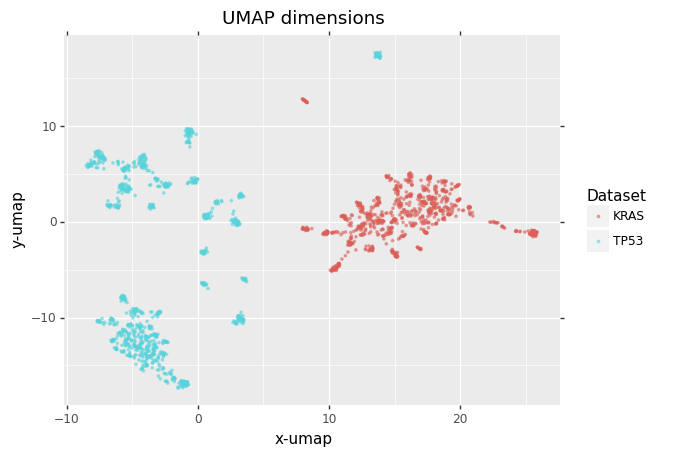

<ggplot: (2935906941064)>

In [183]:
pca_50 = PCA(n_components=50, random_state = 42)
pca_data = pca_50.fit_transform(data)
X_embedded_pr = umap.UMAP(random_state=42, min_dist = 0.5, n_neighbors=30).fit_transform(pca_data)
df_tsne_pr = X_embedded_pr.copy()
df_tsne_pr = pd.DataFrame(df_tsne_pr)
df_tsne_pr['x-umap'] = X_embedded_pr[:,0]
df_tsne_pr['y-umap'] = X_embedded_pr[:,1]
df_tsne_pr['Dataset'] = list(kras_merge['Dataset']) + list(tp53_merge['Dataset']) 
df_tsne_pr['Variant functional class'] = list(kras_merge['Variant functional class']) + list(tp53_merge['Variant functional class']) 
df_tsne_pr['Variant_y'] = list(kras_merge['Variant_y']) + list(tp53_merge['Variant_y']) 

chart_pr = ggplot(df_tsne_pr, aes(x= 'x-umap', y= 'y-umap', colour = 'Dataset') ) \
    + geom_point(size=0.5, alpha = 0.5) \
    + ggtitle("UMAP dimensions")
chart_pr

/home/hengshi/.local/lib/python3.8/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/hengshi/.local/lib/python3.8/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


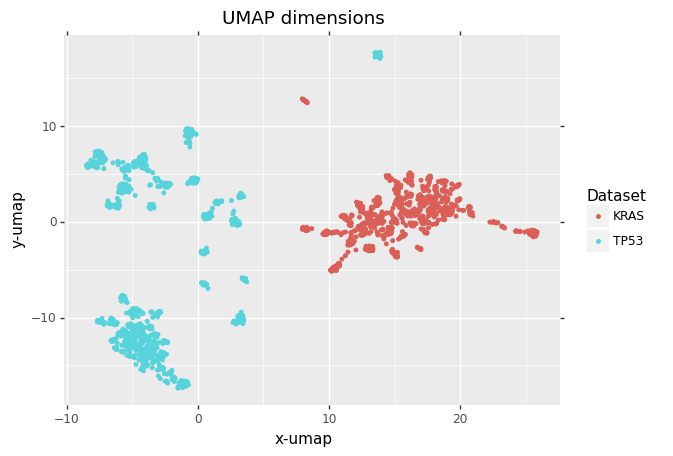

<ggplot: (2935711839115)>

In [184]:
chart_pr = ggplot(df_tsne_pr, aes(x= 'x-umap', y= 'y-umap', colour = 'Dataset') ) \
    + geom_point(size=1, alpha = 1) \
    + ggtitle("UMAP dimensions")
chart_pr

/home/hengshi/.local/lib/python3.8/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/hengshi/.local/lib/python3.8/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


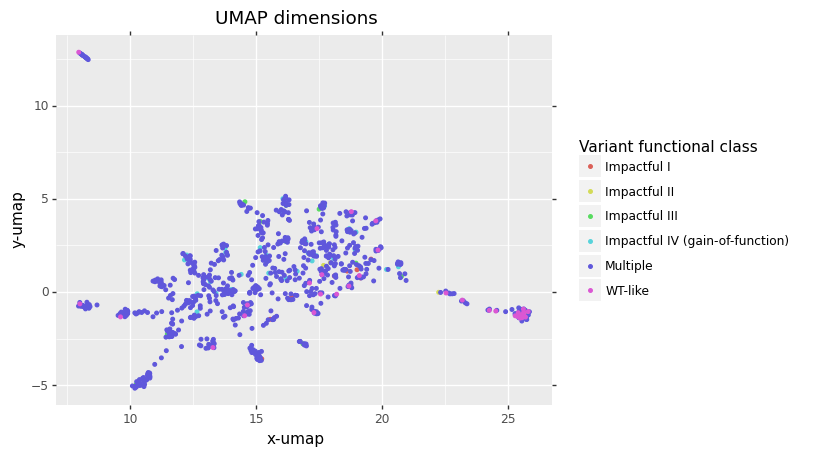

<ggplot: (2935905873487)>

In [186]:
chart_pr = ggplot(df_tsne_pr[((-df_tsne_pr['Variant functional class'].isna())
                             & (df_tsne_pr['Dataset'] == 'KRAS'))], aes(x= 'x-umap', y= 'y-umap', colour = 'Variant functional class') ) \
    + geom_point(size=1, alpha = 1) \
    + ggtitle("UMAP dimensions")
chart_pr

/home/hengshi/.local/lib/python3.8/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/hengshi/.local/lib/python3.8/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


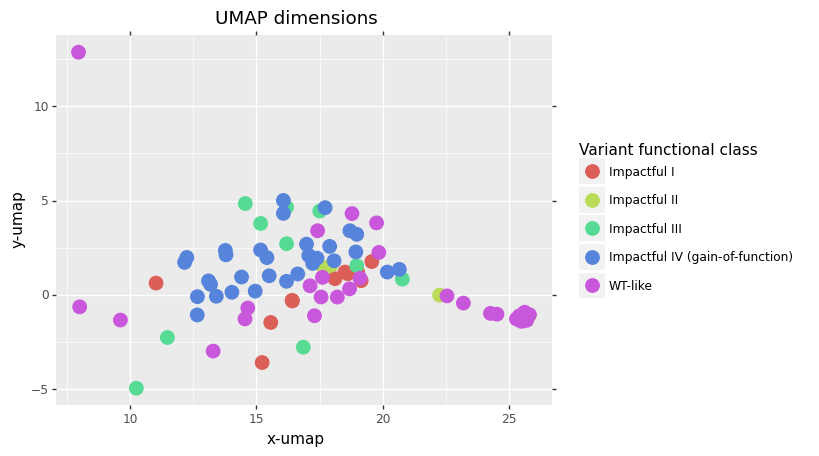

<ggplot: (2935907305198)>

In [188]:
chart_pr = ggplot(df_tsne_pr[((-df_tsne_pr['Variant functional class'].isna())
                             & (df_tsne_pr['Dataset'] == 'KRAS')
                             & (df_tsne_pr['Variant functional class'] != 'Multiple'))], aes(x= 'x-umap', y= 'y-umap', colour = 'Variant functional class') ) \
    + geom_point(size=5, alpha = 1) \
    + ggtitle("UMAP dimensions")
chart_pr

/home/hengshi/.local/lib/python3.8/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/hengshi/.local/lib/python3.8/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


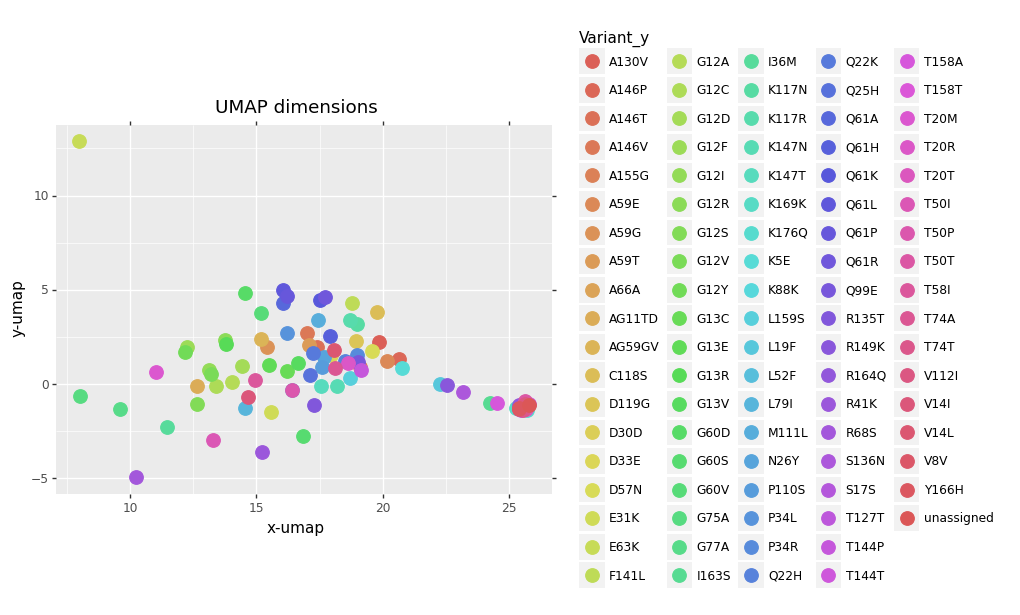

<ggplot: (2935907163784)>

In [189]:
chart_pr = ggplot(df_tsne_pr[((-df_tsne_pr['Variant functional class'].isna())
                             & (df_tsne_pr['Dataset'] == 'KRAS')
                             & (df_tsne_pr['Variant functional class'] != 'Multiple'))], aes(x= 'x-umap', y= 'y-umap', colour = 'Variant_y') ) \
    + geom_point(size=5, alpha = 1) \
    + ggtitle("UMAP dimensions")
chart_pr

/home/hengshi/.local/lib/python3.8/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/hengshi/.local/lib/python3.8/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


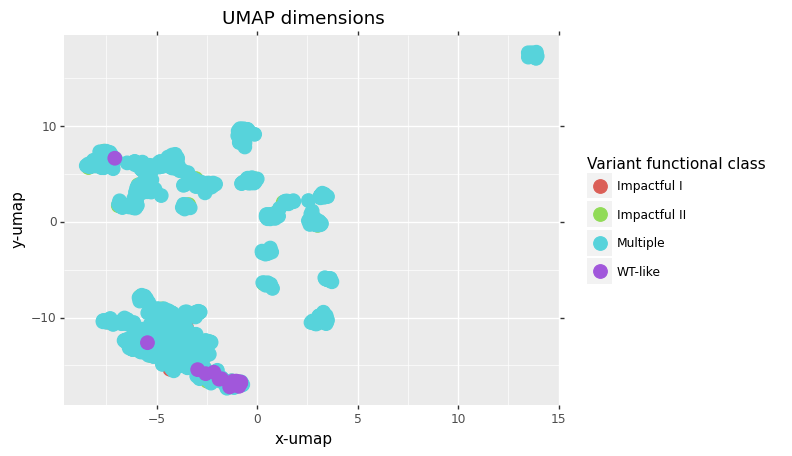

<ggplot: (2935906926836)>

In [192]:
chart_pr = ggplot(df_tsne_pr[((-df_tsne_pr['Variant functional class'].isna())
                             & (df_tsne_pr['Dataset'] == 'TP53')
                             )], aes(x= 'x-umap', y= 'y-umap', colour = 'Variant functional class') ) \
    + geom_point(size=5, alpha = 1) \
    + ggtitle("UMAP dimensions")
chart_pr

/home/hengshi/.local/lib/python3.8/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/hengshi/.local/lib/python3.8/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


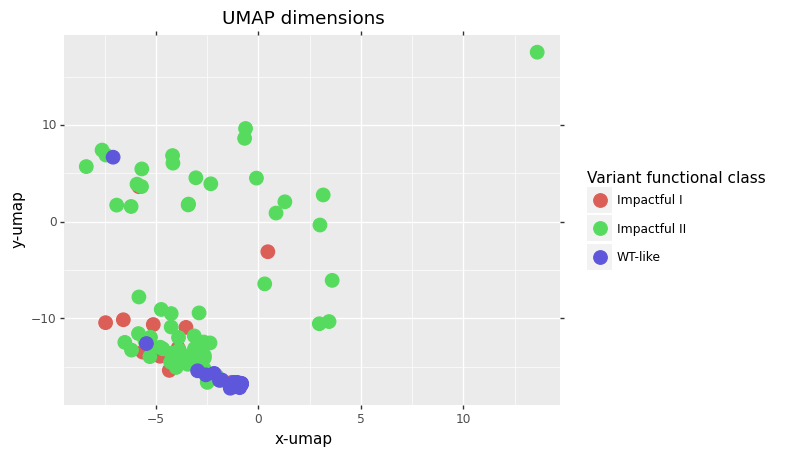

<ggplot: (2935907288116)>

In [190]:
chart_pr = ggplot(df_tsne_pr[((-df_tsne_pr['Variant functional class'].isna())
                             & (df_tsne_pr['Dataset'] == 'TP53')
                             & (df_tsne_pr['Variant functional class'] != 'Multiple'))], aes(x= 'x-umap', y= 'y-umap', colour = 'Variant functional class') ) \
    + geom_point(size=5, alpha = 1) \
    + ggtitle("UMAP dimensions")
chart_pr

/home/hengshi/.local/lib/python3.8/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/hengshi/.local/lib/python3.8/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


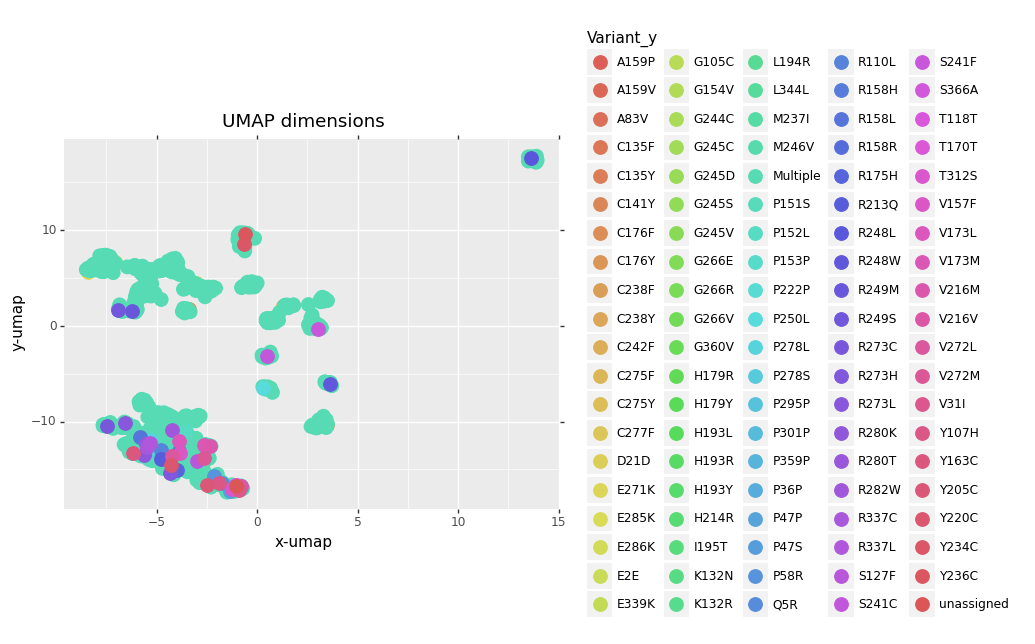

<ggplot: (2935905613403)>

In [191]:
chart_pr = ggplot(df_tsne_pr[((-df_tsne_pr['Variant functional class'].isna())
                             & (df_tsne_pr['Dataset'] == 'TP53'))], aes(x= 'x-umap', y= 'y-umap', colour = 'Variant_y') ) \
    + geom_point(size=5, alpha = 1) \
    + ggtitle("UMAP dimensions")
chart_pr

In [15]:
kras_merge = pd.read_csv('sequence_kras_representation.csv').iloc[:, 1:]
tp53_merge = pd.read_csv('sequence_tp53_representation.csv').iloc[:, 1:]


In [16]:
list_use = list(range(1282)) + [1284]
kras_merge.iloc[:, list_use].head()

,0,1,2,3,4,5,6,7,8,9,...,1273,1274,1275,1276,1277,1278,1279,Variant_x,Dataset,Variant functional class
0,-0.265423,0.179650,-0.225785,-0.206642,-0.557859,0.119581,-0.287248,0.081718,0.058713,-0.099760,...,-0.130913,0.242763,0.073181,0.269573,-0.407178,-0.071867,-0.065996,MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...,KRAS,Impactful IV (gain-of-function)
1,-0.265423,0.179650,-0.225785,-0.206642,-0.557859,0.119581,-0.287248,0.081718,0.058713,-0.099760,...,-0.130913,0.242763,0.073181,0.269573,-0.407178,-0.071867,-0.065996,MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...,KRAS,NaN
2,-0.265423,0.179650,-0.225785,-0.206642,-0.557859,0.119581,-0.287248,0.081718,0.058713,-0.099760,...,-0.130913,0.242763,0.073181,0.269573,-0.407178,-0.071867,-0.065996,MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...,KRAS,NaN
3,-0.265423,0.179650,-0.225785,-0.206642,-0.557859,0.119581,-0.287248,0.081718,0.058713,-0.099760,...,-0.130913,0.242763,0.073181,0.269573,-0.407178,-0.071867,-0.065996,MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...,KRAS,NaN
4,-0.278144,0.181181,-0.236613,-0.208591,-0.564084,0.133692,-0.290223,0.081900,0.060810,-0.100856,...,-0.133544,0.242172,0.066834,0.281539,-0.411984,-0.071758,-0.066045,MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...,KRAS,WT-like


In [17]:
data1 = kras_merge.iloc[:, list_use]

In [26]:
data1.loc[data1['Variant_x'] == base_protein_kras, 'Variant functional class'] = 'WT-like'

/sw/arcts/centos7/python3.8-anaconda/2020.07/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [27]:
data1[data1.iloc[:, :-1].duplicated()]['Variant_x'][1]

'MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVIDGETCLLDILDTAGHEEYSAMRDQYMRTGEGFLCVFAINNTKSFEDIHHYREQIKRVKDSEDVPMVLVGNKCDLPSRTVDTKQAQDLARSYGIPFIETSAKTRQRVEDAFYTLVREIRQYRLKKISKEEKTPGCVKIKKCIIM'

In [28]:
kras_merge[kras_merge['Variant_x'] == 'MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVIDGETCLLDILDTAGHEEYSAMRDQYMRTGEGFLCVFAINNTKSFEDIHHYREQIKRVKDSEDVPMVLVGNKCDLPSRTVDTKQAQDLARSYGIPFIETSAKTRQRVEDAFYTLVREIRQYRLKKISKEEKTPGCVKIKKCIIM']

,0,1,2,3,4,5,6,7,8,9,...,1275,1276,1277,1278,1279,Variant_x,Dataset,Variant_y,Sequence,Variant functional class
0,-0.265423,0.17965,-0.225785,-0.206642,-0.557859,0.119581,-0.287248,0.081718,0.058713,-0.09976,...,0.073181,0.269573,-0.407178,-0.071867,-0.065996,MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...,KRAS,Q61H,MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...,Impactful IV (gain-of-function)
1,-0.265423,0.17965,-0.225785,-0.206642,-0.557859,0.119581,-0.287248,0.081718,0.058713,-0.09976,...,0.073181,0.269573,-0.407178,-0.071867,-0.065996,MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...,KRAS,Multiple,MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...,NaN
2,-0.265423,0.17965,-0.225785,-0.206642,-0.557859,0.119581,-0.287248,0.081718,0.058713,-0.09976,...,0.073181,0.269573,-0.407178,-0.071867,-0.065996,MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...,KRAS,Multiple,MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...,NaN
3,-0.265423,0.17965,-0.225785,-0.206642,-0.557859,0.119581,-0.287248,0.081718,0.058713,-0.09976,...,0.073181,0.269573,-0.407178,-0.071867,-0.065996,MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...,KRAS,Multiple,MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...,NaN


In [29]:
data1['Variant functional class'].unique()

array(['Impactful IV (gain-of-function)', nan, 'WT-like', 'Impactful II',
       'Impactful I', 'Impactful III'], dtype=object)

In [30]:
data1.shape

(831, 1283)

In [31]:
data1_single = data1[(-data1['Variant functional class'].isna())]
data1_multiple = data1[(data1['Variant functional class'].isna())]
data1_single.shape, data1_multiple.shape

((107, 1283), (724, 1283))

In [32]:
data1_single.head()

,0,1,2,3,4,5,6,7,8,9,...,1273,1274,1275,1276,1277,1278,1279,Variant_x,Dataset,Variant functional class
0,-0.265423,0.179650,-0.225785,-0.206642,-0.557859,0.119581,-0.287248,0.081718,0.058713,-0.099760,...,-0.130913,0.242763,0.073181,0.269573,-0.407178,-0.071867,-0.065996,MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...,KRAS,Impactful IV (gain-of-function)
4,-0.278144,0.181181,-0.236613,-0.208591,-0.564084,0.133692,-0.290223,0.081900,0.060810,-0.100856,...,-0.133544,0.242172,0.066834,0.281539,-0.411984,-0.071758,-0.066045,MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...,KRAS,WT-like
5,-0.278144,0.181181,-0.236613,-0.208591,-0.564084,0.133692,-0.290223,0.081900,0.060810,-0.100856,...,-0.133544,0.242172,0.066834,0.281539,-0.411984,-0.071758,-0.066045,MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...,KRAS,WT-like
6,-0.278144,0.181181,-0.236613,-0.208591,-0.564084,0.133692,-0.290223,0.081900,0.060810,-0.100856,...,-0.133544,0.242172,0.066834,0.281539,-0.411984,-0.071758,-0.066045,MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...,KRAS,WT-like
7,-0.278144,0.181181,-0.236613,-0.208591,-0.564084,0.133692,-0.290223,0.081900,0.060810,-0.100856,...,-0.133544,0.242172,0.066834,0.281539,-0.411984,-0.071758,-0.066045,MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...,KRAS,WT-like


In [33]:
list_per = np.array(list(data1_single['Variant_x']))
list_per

array(['MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVIDGETCLLDILDTAGHEEYSAMRDQYMRTGEGFLCVFAINNTKSFEDIHHYREQIKRVKDSEDVPMVLVGNKCDLPSRTVDTKQAQDLARSYGIPFIETSAKTRQRVEDAFYTLVREIRQYRLKKISKEEKTPGCVKIKKCIIM',
       'MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVIDGETCLLDILDTAGQEEYSAMRDQYMRTGEGFLCVFAINNTKSFEDIHHYREQIKRVKDSEDVPMVLVGNKCDLPSRTVDTKQAQDLARSYGIPFIETSAKTRQRVEDAFYTLVREIRQYRLKKISKEEKTPGCVKIKKCIIM',
       'MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVIDGETCLLDILDTAGQEEYSAMRDQYMRTGEGFLCVFAINNTKSFEDIHHYREQIKRVKDSEDVPMVLVGNKCDLPSRTVDTKQAQDLARSYGIPFIETSAKTRQRVEDAFYTLVREIRQYRLKKISKEEKTPGCVKIKKCIIM',
       'MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVIDGETCLLDILDTAGQEEYSAMRDQYMRTGEGFLCVFAINNTKSFEDIHHYREQIKRVKDSEDVPMVLVGNKCDLPSRTVDTKQAQDLARSYGIPFIETSAKTRQRVEDAFYTLVREIRQYRLKKISKEEKTPGCVKIKKCIIM',
       'MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVIDGETCLLDILDTAGQEEYSAMRDQYMRTGEGFLCVFAINNTKSFEDIHHYREQIKRVKDSEDVPMVLVGNKCDLPSRTVDTKQAQDLARSYGIPFIETSAKTRQRVEDAFYTLVREIRQYRLKKISKEEKTPGCVKIKKCIIM',


In [34]:
data1_multiple = data1_multiple.drop_duplicates()
list_perM = list(data1_multiple['Variant_x'])
indice_kept = [i for i in range(len(list_perM)) if list_perM[i] not in list_per]
data1_multiple = data1_multiple.iloc[indice_kept, :]

In [35]:
data1 = pd.concat((data1_single.drop_duplicates(), data1_multiple), axis = 0)

In [36]:
data1.shape

(623, 1283)

In [37]:
data2 = tp53_merge.iloc[:, list_use]
data2.loc[data2['Variant_x'] == base_protein_tp53, 'Variant functional class'] = 'WT-like'

data2_single = data2[data2['Variant functional class'] != 'Multiple']
data2_multiple = data2[data2['Variant functional class'] == 'Multiple']
data2_single.shape, data2_multiple.shape

/sw/arcts/centos7/python3.8-anaconda/2020.07/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


((988, 1283), (0, 1283))

In [38]:
list_per = np.array(list(data2_single['Variant_x']))

data2_multiple = data2_multiple.drop_duplicates()
list_perM = list(data2_multiple['Variant_x'])
indice_kept = [i for i in range(len(list_perM)) if list_perM[i] not in list_per]
data2_multiple = data2_multiple.iloc[indice_kept, :]

In [39]:
data2 = pd.concat((data2_single.drop_duplicates(), data2_multiple), axis = 0)

In [40]:
data2.shape

(875, 1283)

In [41]:
data1.shape

(623, 1283)

In [42]:
data = np.concatenate((data1.iloc[:, :1280].values,
                       data2.iloc[:, :1280].values))

In [43]:
data.shape

(1498, 1280)

/home/hengshi/.local/lib/python3.8/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/hengshi/.local/lib/python3.8/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


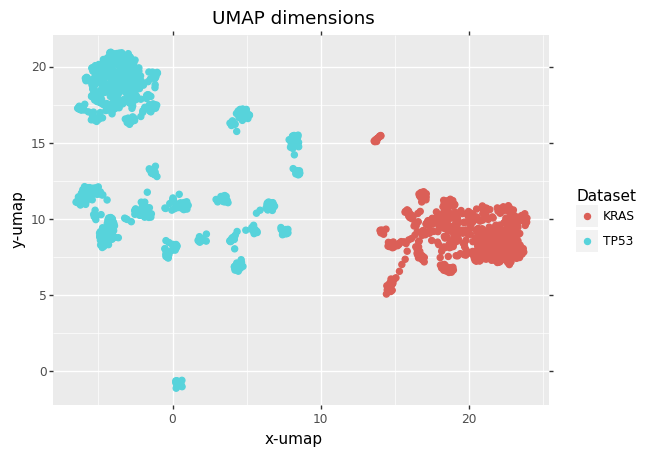

<ggplot: (2938958180063)>

In [46]:
pca_50 = PCA(n_components=50, random_state = 42)
pca_data = pca_50.fit_transform(data)
X_embedded_pr = umap.UMAP(random_state=42, min_dist = 0.5, n_neighbors=30).fit_transform(pca_data)
df_tsne_pr = X_embedded_pr.copy()
df_tsne_pr = pd.DataFrame(df_tsne_pr)
df_tsne_pr['x-umap'] = X_embedded_pr[:,0]
df_tsne_pr['y-umap'] = X_embedded_pr[:,1]
df_tsne_pr['Dataset'] = ['KRAS'] * data1.shape[0] + ['TP53'] * data2.shape[0]
df_tsne_pr['Variant functional class'] = list(data1['Variant functional class']) + list(data2['Variant functional class']) 

chart_pr = ggplot(df_tsne_pr, aes(x= 'x-umap', y= 'y-umap', colour = 'Dataset') ) \
    + geom_point(size=2, alpha = 1) \
    + ggtitle("UMAP dimensions")
chart_pr

In [48]:
pca_data.var(0).min(), pca_data.max()

(0.00040012534394633434, 5.681142599964995)

In [55]:
np.mean(pca_data.var(0) < 0.0005)

0.12

/home/hengshi/.local/lib/python3.8/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/hengshi/.local/lib/python3.8/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


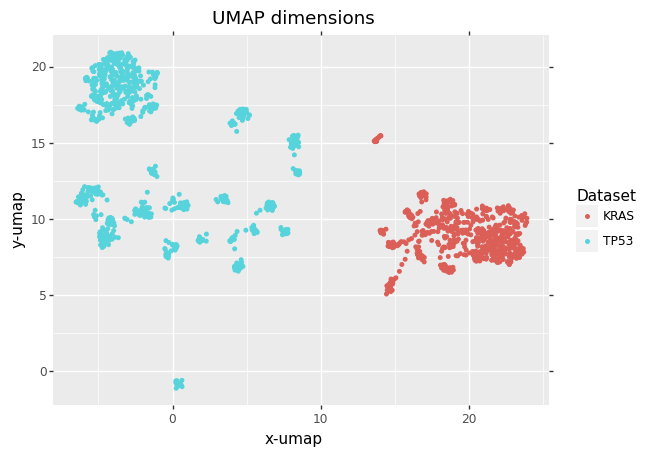

<ggplot: (2938958075462)>

In [56]:

chart_pr = ggplot(df_tsne_pr, aes(x= 'x-umap', y= 'y-umap', colour = 'Dataset') ) \
    + geom_point(size=1, alpha = 1) \
    + ggtitle("UMAP dimensions")
chart_pr

/home/hengshi/.local/lib/python3.8/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/hengshi/.local/lib/python3.8/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


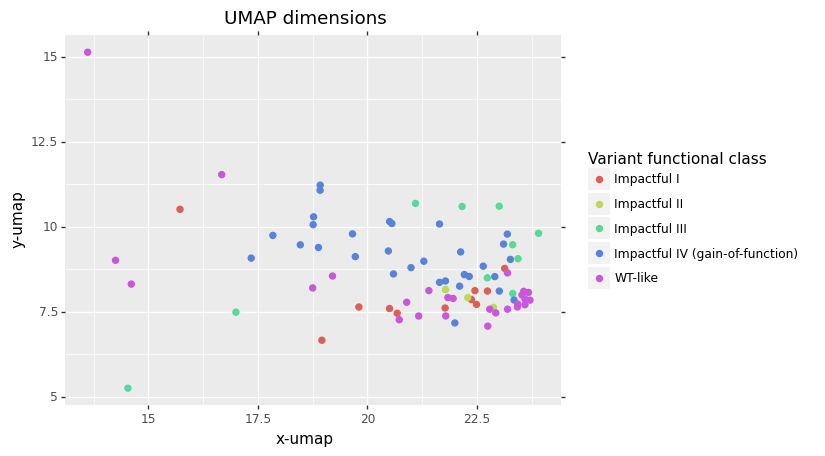

<ggplot: (2938958561052)>

In [57]:
chart_pr = ggplot(df_tsne_pr[((-df_tsne_pr['Variant functional class'].isna())
                             & (df_tsne_pr['Dataset'] == 'KRAS'))], aes(x= 'x-umap', y= 'y-umap', colour = 'Variant functional class') ) \
    + geom_point(size=2, alpha = 1) \
    + ggtitle("UMAP dimensions")
chart_pr

/home/hengshi/.local/lib/python3.8/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/hengshi/.local/lib/python3.8/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


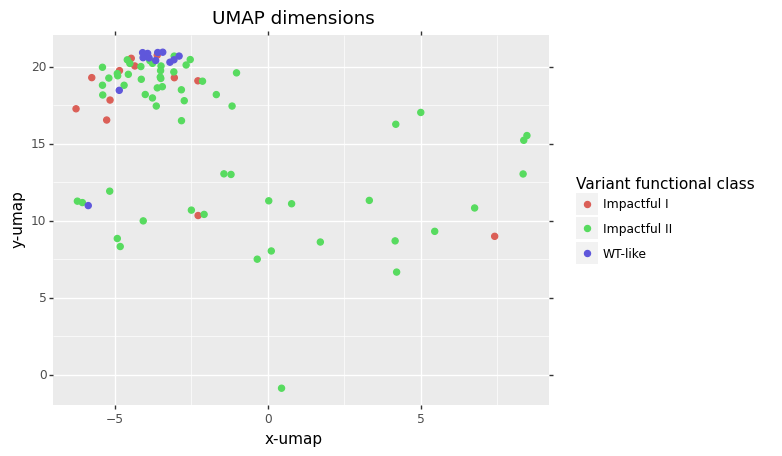

<ggplot: (2938958042637)>

In [58]:
chart_pr = ggplot(df_tsne_pr[((-df_tsne_pr['Variant functional class'].isna())
                             & (df_tsne_pr['Dataset'] == 'TP53'))], aes(x= 'x-umap', y= 'y-umap', colour = 'Variant functional class') ) \
    + geom_point(size=2, alpha = 1) \
    + ggtitle("UMAP dimensions")
chart_pr

/home/hengshi/.local/lib/python3.8/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/hengshi/.local/lib/python3.8/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


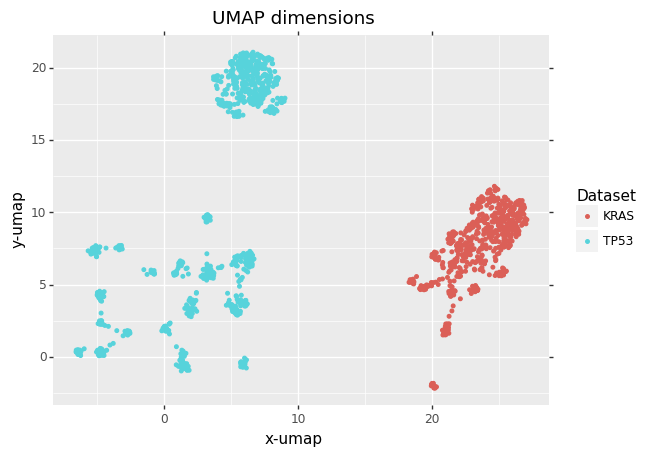

<ggplot: (2938988976731)>

In [63]:
pca_50 = PCA(n_components=50, random_state = 42)
pca_data = pca_50.fit_transform(data +  np.random.normal(scale = 0.001, size = data.shape))
X_embedded_pr = umap.UMAP(random_state=42, min_dist = 0.5, n_neighbors=30).fit_transform(pca_data)
df_tsne_pr = X_embedded_pr.copy()
df_tsne_pr = pd.DataFrame(df_tsne_pr)
df_tsne_pr['x-umap'] = X_embedded_pr[:,0]
df_tsne_pr['y-umap'] = X_embedded_pr[:,1]
df_tsne_pr['Dataset'] = ['KRAS'] * data1.shape[0] + ['TP53'] * data2.shape[0]
df_tsne_pr['Variant functional class'] = list(data1['Variant functional class']) + list(data2['Variant functional class']) 

chart_pr = ggplot(df_tsne_pr, aes(x= 'x-umap', y= 'y-umap', colour = 'Dataset') ) \
    + geom_point(size=1, alpha = 1) \
    + ggtitle("UMAP dimensions")
chart_pr

/home/hengshi/.local/lib/python3.8/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/hengshi/.local/lib/python3.8/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


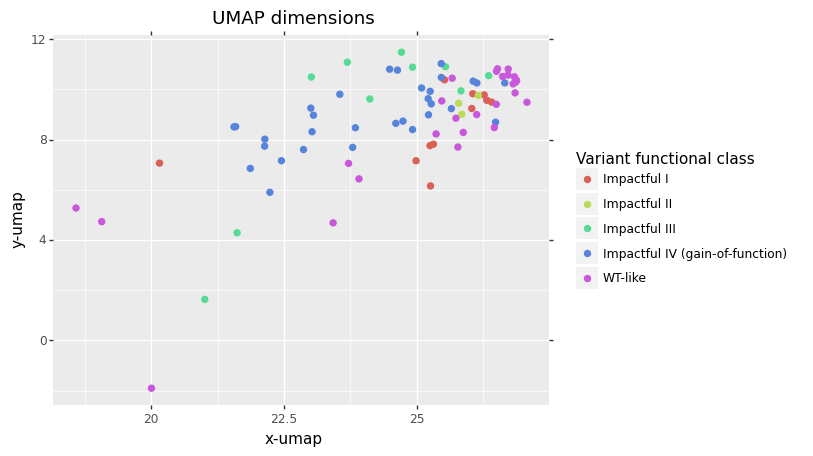

<ggplot: (2938958338868)>

In [64]:
chart_pr = ggplot(df_tsne_pr[((-df_tsne_pr['Variant functional class'].isna())
                             & (df_tsne_pr['Dataset'] == 'KRAS'))], aes(x= 'x-umap', y= 'y-umap', colour = 'Variant functional class') ) \
    + geom_point(size=2, alpha = 1) \
    + ggtitle("UMAP dimensions")
chart_pr

/home/hengshi/.local/lib/python3.8/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/hengshi/.local/lib/python3.8/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


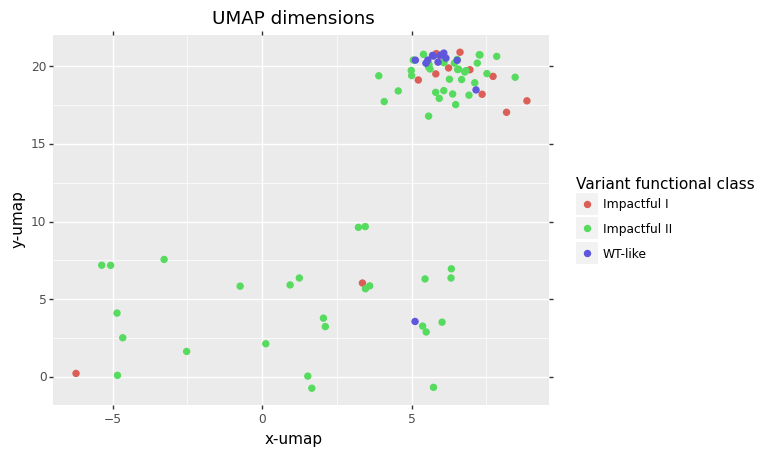

<ggplot: (2938958705595)>

In [65]:
chart_pr = ggplot(df_tsne_pr[((-df_tsne_pr['Variant functional class'].isna())
                             & (df_tsne_pr['Dataset'] == 'TP53'))], aes(x= 'x-umap', y= 'y-umap', colour = 'Variant functional class') ) \
    + geom_point(size=2, alpha = 1) \
    + ggtitle("UMAP dimensions")
chart_pr

/home/hengshi/.local/lib/python3.8/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/hengshi/.local/lib/python3.8/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


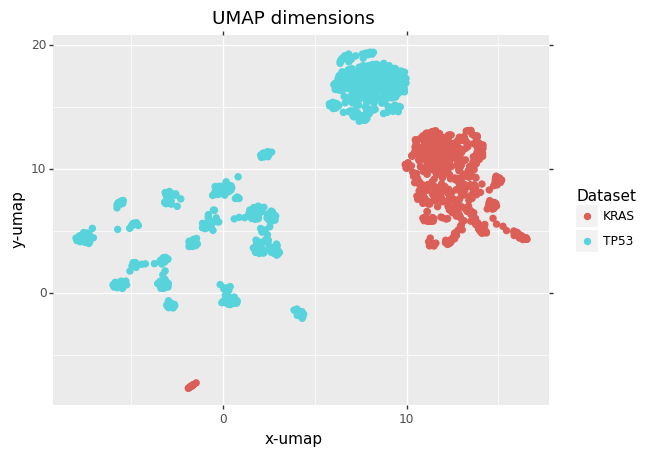

<ggplot: (2939041010164)>

In [66]:
X_embedded_pr = umap.UMAP(random_state=42, min_dist = 0.5, n_neighbors=30).fit_transform(pca_data +  np.random.normal(scale = 0.0005, size = pca_data.shape))
df_tsne_pr = X_embedded_pr.copy()
df_tsne_pr = pd.DataFrame(df_tsne_pr)
df_tsne_pr['x-umap'] = X_embedded_pr[:,0]
df_tsne_pr['y-umap'] = X_embedded_pr[:,1]
df_tsne_pr['Dataset'] = ['KRAS'] * data1.shape[0] + ['TP53'] * data2.shape[0]
df_tsne_pr['Variant functional class'] = list(data1['Variant functional class']) + list(data2['Variant functional class']) 

chart_pr = ggplot(df_tsne_pr, aes(x= 'x-umap', y= 'y-umap', colour = 'Dataset') ) \
    + geom_point(size=2, alpha = 1) \
    + ggtitle("UMAP dimensions")
chart_pr

/home/hengshi/.local/lib/python3.8/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/hengshi/.local/lib/python3.8/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


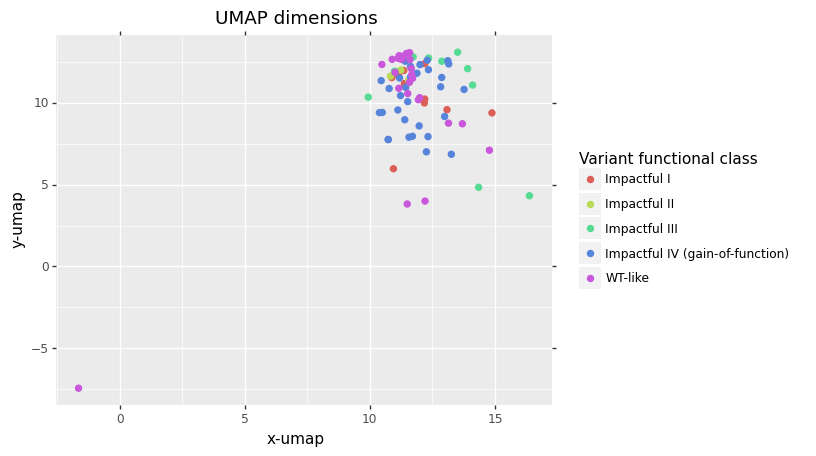

<ggplot: (2938989102746)>

In [67]:
chart_pr = ggplot(df_tsne_pr[((-df_tsne_pr['Variant functional class'].isna())
                             & (df_tsne_pr['Dataset'] == 'KRAS'))], aes(x= 'x-umap', y= 'y-umap', colour = 'Variant functional class') ) \
    + geom_point(size=2, alpha = 1) \
    + ggtitle("UMAP dimensions")
chart_pr

/home/hengshi/.local/lib/python3.8/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/hengshi/.local/lib/python3.8/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


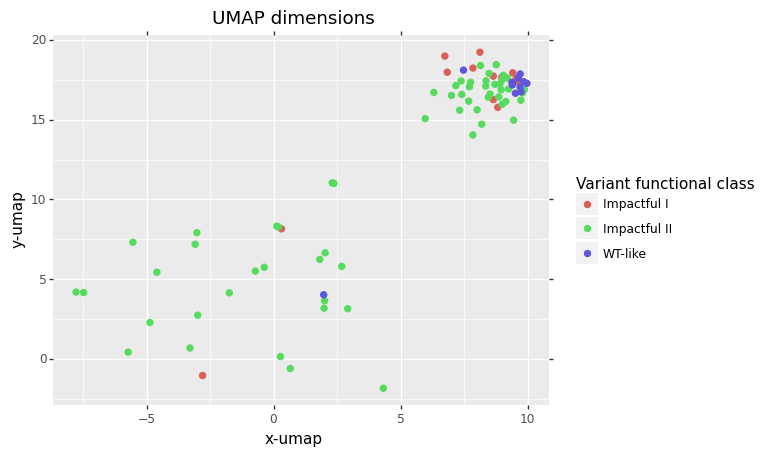

<ggplot: (2938989091837)>

In [68]:
chart_pr = ggplot(df_tsne_pr[((-df_tsne_pr['Variant functional class'].isna())
                             & (df_tsne_pr['Dataset'] == 'TP53'))], aes(x= 'x-umap', y= 'y-umap', colour = 'Variant functional class') ) \
    + geom_point(size=2, alpha = 1) \
    + ggtitle("UMAP dimensions")
chart_pr

In [282]:
data = np.concatenate((kras_merge.iloc[:, :1280].values,
               tp53_merge.iloc[:, :1280].values))

/home/hengshi/.local/lib/python3.8/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/hengshi/.local/lib/python3.8/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


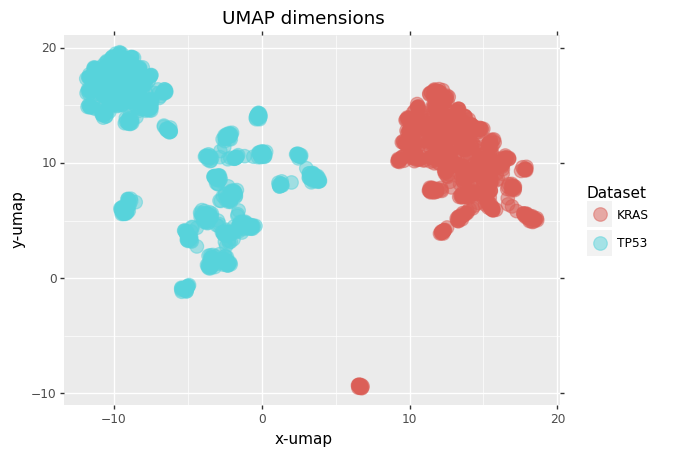

<ggplot: (2935906044666)>

In [288]:
pca_50 = PCA(n_components=50, random_state = 42)

pca_data = pca_50.fit_transform(data +  np.random.normal(scale = 0.001, size = data.shape))
X_embedded_pr = umap.UMAP(random_state=42, min_dist = 0.5, n_neighbors=30).fit_transform(pca_data)
df_tsne_pr = X_embedded_pr.copy()
df_tsne_pr = pd.DataFrame(df_tsne_pr)
df_tsne_pr['x-umap'] = X_embedded_pr[:,0]
df_tsne_pr['y-umap'] = X_embedded_pr[:,1]
df_tsne_pr['Dataset'] = list(kras_merge['Dataset']) + list(tp53_merge['Dataset']) 
df_tsne_pr['Variant functional class'] = list(kras_merge['Variant functional class']) + list(tp53_merge['Variant functional class']) 
df_tsne_pr['Variant_y'] = list(kras_merge['Variant_y']) + list(tp53_merge['Variant_y']) 

chart_pr = ggplot(df_tsne_pr, aes(x= 'x-umap', y= 'y-umap', colour = 'Dataset') ) \
    + geom_point(size=5, alpha = 0.5) \
    + ggtitle("UMAP dimensions")
chart_pr

/home/hengshi/.local/lib/python3.8/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/hengshi/.local/lib/python3.8/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


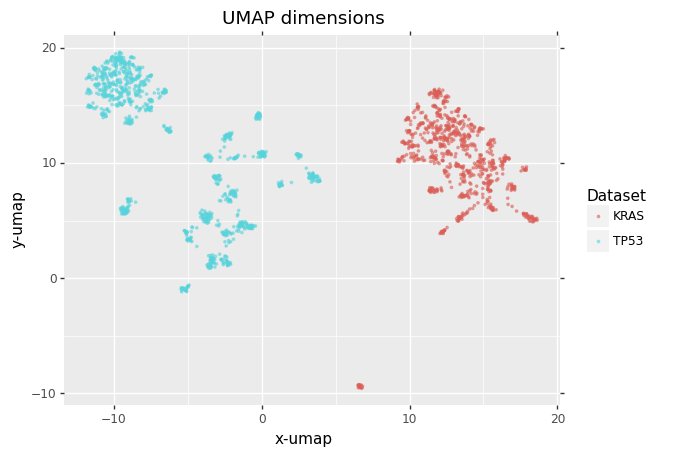

<ggplot: (2935906044420)>

In [289]:
chart_pr = ggplot(df_tsne_pr, aes(x= 'x-umap', y= 'y-umap', colour = 'Dataset') ) \
    + geom_point(size=0.5, alpha = 0.5) \
    + ggtitle("UMAP dimensions")
chart_pr

/home/hengshi/.local/lib/python3.8/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/hengshi/.local/lib/python3.8/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


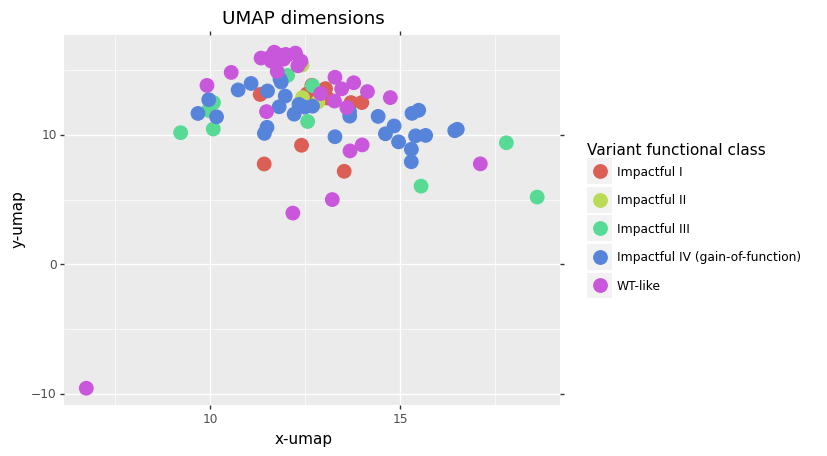

<ggplot: (2935712099880)>

In [290]:
chart_pr = ggplot(df_tsne_pr[((-df_tsne_pr['Variant functional class'].isna())
                             & (df_tsne_pr['Dataset'] == 'KRAS')
                             & (df_tsne_pr['Variant functional class'] != 'Multiple'))], aes(x= 'x-umap', y= 'y-umap', colour = 'Variant functional class') ) \
    + geom_point(size=5, alpha = 1) \
    + ggtitle("UMAP dimensions")
chart_pr

/home/hengshi/.local/lib/python3.8/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/hengshi/.local/lib/python3.8/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


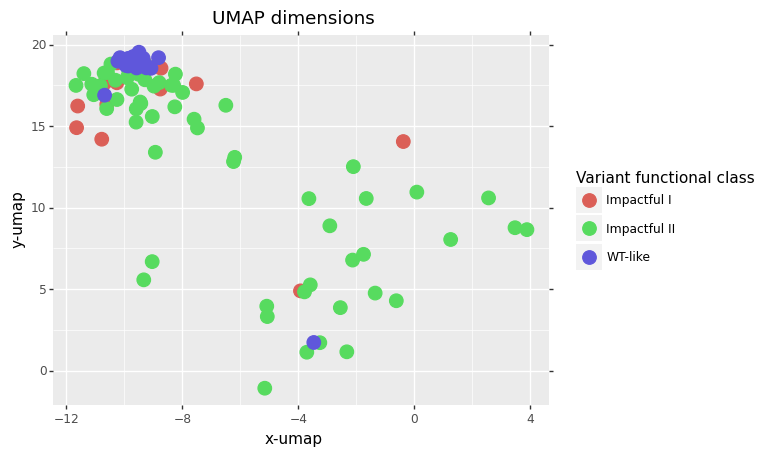

<ggplot: (2935711798794)>

In [291]:
chart_pr = ggplot(df_tsne_pr[((-df_tsne_pr['Variant functional class'].isna())
                             & (df_tsne_pr['Dataset'] == 'TP53')
                             & (df_tsne_pr['Variant functional class'] != 'Multiple'))], aes(x= 'x-umap', y= 'y-umap', colour = 'Variant functional class') ) \
    + geom_point(size=5, alpha = 1) \
    + ggtitle("UMAP dimensions")
chart_pr

In [69]:
a =b =10

In [70]:
a

10

In [71]:
b

10